# Pypi network evolution

##### Setup olivia

In [2]:
# Olivia Finder requirements
%pip install -r ../olivia/requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import tqdm
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import os
from time import time
import networkx as nx
import psutil
from collections import Counter

# Append the path to the olivia_finder package
import sys
sys.path.append('../../olivia/')

from olivia.model import OliviaNetwork


Set up variables

In [4]:
REPO_NAME = "CRAN"
OUT_IMG_DIR = f"../img/{REPO_NAME}"

# Create output directory
if not os.path.exists(OUT_IMG_DIR):
    os.makedirs(OUT_IMG_DIR)



#### **Utilities**

In [5]:

def add_chunk(
    df, G, dependent_field, dependency_field,
    filter_field=None,
    filter_value=None
):
    """ Utility method for build_dependency_network"""
    filtered = df[df[filter_field] == filter_value] if filter_field else df
    links = list(zip(filtered[dependency_field], filtered[dependent_field]))
    G.add_edges_from(links)
    return G

def build_dependency_network(
    df,
    chunk_size,
    dependent_field: str = 'Project Name',
    dependency_field: str = 'Dependency Name',
    filter_field=None,
    filter_value=None,
    verbose: bool = True
):
    # Print only if verbose
    vprint = print if verbose else lambda *a, **k: None
    process = psutil.Process(os.getpid())
    vprint("Using process ", process)
    t = time()
    try:
        vprint('Initializing graph... ', end='')
        # New NetworkX directed Graph
        G = nx.DiGraph()
        vprint('OK')
        
        # Split DataFrame into chunks
        chunks = [df[i:i + chunk_size] for i in range(0, len(df), chunk_size)]
        
        for i, chunk in enumerate(chunks):
            # Add dependencies from chunk to G
            add_chunk(
                chunk, 
                G,
                dependent_field=dependent_field,
                dependency_field=dependency_field,
                filter_field=filter_field,
                filter_value=filter_value
            )
            vprint(f'{round(i*chunk_size/1e6,1)}M lines | {len(G)} nodes, {len(G.edges)} deps. ({int(time()-t)}s) {round(process.memory_info().rss/1e6,1)}Mb')
        vprint('Done processing DataFrame')
        
        return G
    
    except Exception as e:
        print('\n', e)

def plot_degree_distribution(G, title, color, save=False, filename=None):
    '''
    Plot the degree distribution of a networkx graph
    '''

    # Nodes' degree vector
    degree=[x[1] for x in G.degree()]
    
    # Create subplots
    fig, axs = plt.subplots(1, 2, figsize=(10, 4))

    # Set title
    fig.suptitle(title, fontsize=20, fontweight='bold')
    
    # Plot linear histogram
    # Order nodes' degree vector
    sorted_degree = sorted(degree, reverse=True)
    axs[0].plot(sorted_degree, color=color)
    axs[0].set_xlabel('Nodes')
    axs[0].set_ylabel('Degree')
    axs[0].set_yscale('log')
    
    
    # Plot histogram with log scale
    axs[1].hist(degree, bins=100, color=color)
    axs[1].set_xlabel('Degree')
    axs[1].set_ylabel('Number of nodes')
    axs[1].set_xscale('log')
    axs[1].set_yscale('log')

    # Save figure
    if save:
        plt.savefig(filename, bbox_inches='tight')
    
    plt.show()

def draw_networkx_graph(G, layout='circular', size=(20,20)):
    '''
    Draw a networkx graph
    '''

    layouts = {
        'circular': nx.circular_layout,
        'kamada_kawai': nx.kamada_kawai_layout,
        'random': nx.random_layout,
        'shell': nx.shell_layout,
        'spring': nx.spring_layout,
        'spectral': nx.spectral_layout,
        'random': nx.random_layout,
    }
    plt.figure(figsize=size)
    pos = layouts[layout](G)
    node_size = [G.in_degree(node) * 80 for node in G]
    node_color = [G.in_degree(node) for node in G]
    edge_color = 'black'
    width = 1
    nx.draw_networkx(G, pos=pos, node_size=node_size, node_color=node_color, alpha=0.7,
                     with_labels=False, edge_color=edge_color, width=width)
    
    # Agregar etiquetas personalizadas
    labels = {node: node for node in G.nodes()}
    node_labels = nx.draw_networkx_labels(G, pos=pos, labels=labels, font_size=8,
                                          font_weight='bold', bbox=dict(facecolor='red', edgecolor='none', pad=0.3))

    plt.gca().set_aspect('equal')
    plt.axis('off')
    plt.show()


def draw_package_deep_network(G, package_name, deep, size=(10, 10), layout='spring', title=None):
    '''
    Draw the subgraph of a package and its dependencies up to a certain depth.

    '''

    layouts = {
        'circular': nx.circular_layout,
        'kamada_kawai': nx.kamada_kawai_layout,
        'random': nx.random_layout,
        'shell': nx.shell_layout,
        'spring': nx.spring_layout,
        'spectral': nx.spectral_layout,
    }

    # Create a subgraph of the package and its dependencies up to a certain depth
    # subgraph = nx.ego_graph(G, package_name, radius=deep, center=True)
    subgraph = nx.ego_graph(G, package_name, radius=deep, center=True)

    # Draw the subgraph
    plt.figure(figsize=size)
    pos = layouts[layout](subgraph)
    node_size = [subgraph.in_degree(node) * 100 for node in subgraph]
    node_color = [subgraph.in_degree(node) for node in subgraph]
    edge_color = 'black'
    width = 1
    nx.draw_networkx(subgraph, pos=pos, node_size=node_size, node_color=node_color, alpha=0.7,
                        with_labels=False, edge_color=edge_color, width=width)
    
    # Add title
    if title:
        plt.title(title, fontsize=16, fontweight='bold')


    # Set target node square in blue
    nx.draw_networkx_nodes(subgraph, pos=pos, nodelist=[package_name], node_size=100, node_color='blue', alpha=0.7)

    # Add custom labels
    labels = {node: node for node in subgraph.nodes()}
    nx.draw_networkx_labels(
        subgraph, pos=pos, labels=labels, font_size=8,
        font_weight='bold', bbox=dict(facecolor='red', edgecolor='none', pad=0.3)
    )
    
    plt.gca().set_aspect('equal')
    plt.axis('off')
    plt.show()

    return subgraph

# def plot_comparation(m1, m2, t_m1, t_m2, offset=0):
#     plt.figure(figsize=(15, 3))
    
#     # Gráfico para libraries.io
#     plt.subplot(1, 2, 1)
#     plt.bar([x[0] for x in m1], [x[1] for x in m1], color='orange')
#     plt.xticks(rotation=90)
#     plt.title(t_m1, fontsize=14, fontweight='bold')
#     plt.ylabel(t_m1)
#     plt.grid(axis='y', linestyle='--', alpha=0.7)
#     plt.gca().spines['top'].set_visible(False)
#     plt.gca().spines['right'].set_visible(False)
#     plt.gca().tick_params(axis='x', labelsize=12)
#     plt.gca().tick_params(axis='y', labelsize=12)
#     bar_size = [x[1] for x in m1]
#     for i in range(len(m1)):
#         plt.text(i, bar_size[i] + offset , str(bar_size[i]), ha='center', va='center', color='black')

#     # Gráfico para Scraped Packages
#     plt.subplot(1, 2, 2)
#     plt.bar([x[0] for x in m2], [x[1] for x in m2], color='purple')
#     plt.xticks(rotation=90)
#     plt.title(t_m2, fontsize=14, fontweight='bold')
#     plt.ylabel(t_m2)
#     plt.grid(axis='y', linestyle='--', alpha=0.7)
#     plt.gca().spines['top'].set_visible(False)
#     plt.gca().spines['right'].set_visible(False)
#     plt.gca().tick_params(axis='x', labelsize=12)
#     plt.gca().tick_params(axis='y', labelsize=12)
#     bar_size = [x[1] for x in m2]
#     for i in range(len(m2)):
#         plt.text(i, bar_size[i] + offset, str(bar_size[i]), ha='center', va='center', color='white')

#     plt.show()

def plot_comparison(
        ss, tt_G, save=False, filename=None, 
        xticks_rotation=0, bar_offset=0, xticks_size=16, 
        font_size=14, rotation=90, tittle=None, metric=None, comparable=None):
    
    tt = []
    for node in ss:
        if node[0] in tt_G.nodes():
            tt.append((node[0], comparable[node[0]]))
        else:
            tt.append((node[0], 0))

    # Plot comparison
    plt.figure(figsize=(15, 3))

    colors = ['orange', 'purple']

    plt.bar(
        [x[0] for x in tt],
        [x[1] for x in tt],
        label='Scraped',
        color=colors[1],
        width=0.4,
        alpha=1,
        hatch='..'
    )

    plt.bar(
        [x[0] for x in ss],
        [x[1] for x in ss],
        label='Libraries.io',
        color=colors[0],
        width=0.6,
        alpha=0.6
    )

    for i, v, i2, v2 in zip([x[0] for x in tt], [x[1] for x in tt], [x[0] for x in ss], [x[1] for x in ss]):
        plt.text(i, max(v, v2) + bar_offset, f'{v} - {v2}', color='black', ha='center', rotation=rotation, fontsize=font_size)


    # Adjusting plot borders
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)

    # Adjusting tick labels font size
    plt.gca().tick_params(axis='x', labelsize=xticks_size)
    plt.gca().tick_params(axis='y', labelsize=xticks_size)

    plt.title(tittle, fontsize=20, fontweight='bold', pad=50)
    plt.xlabel('Package name')
    plt.ylabel(metric)
    plt.xticks(rotation=xticks_rotation)
    plt.legend()

    if save:
        plt.savefig(filename, bbox_inches='tight')

    plt.show()


def plot_comparison_reversed(
        ss, tt_G, save=False, filename=None, 
        xticks_rotation=0, bar_offset=0, xticks_size=16, 
        font_size=14, rotation=90, tittle=None, metric=None, comparable=None):
    
    tt = []
    for node in ss:
        if node[0] in tt_G.nodes():
            tt.append((node[0], comparable[node[0]]))
        else:
            tt.append((node[0], 0))

    # Plot comparison
    plt.figure(figsize=(15, 3))

    colors = ['orange', 'purple']

    plt.bar(
        [x[0] for x in ss],
        [x[1] for x in ss],
        label='Scraped',
        color=colors[1],
        width=0.4,
        alpha=1,
        hatch='..'
    )

    plt.bar(
        [x[0] for x in tt],
        [x[1] for x in tt],
        label='Libraries.io',
        color=colors[0],
        width=0.6,
        alpha=0.6
    )

    for i, v, i2, v2 in zip([x[0] for x in tt], [x[1] for x in tt], [x[0] for x in ss], [x[1] for x in ss]):
        plt.text(i, max(v, v2) + bar_offset, f'{v} - {v2}', color='black', ha='center', rotation=rotation, fontsize=font_size)


    # Adjusting plot borders
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)

    # Adjusting tick labels font size
    plt.gca().tick_params(axis='x', labelsize=xticks_size)
    plt.gca().tick_params(axis='y', labelsize=xticks_size)

    plt.title(tittle, fontsize=20, fontweight='bold', pad=50)
    plt.xlabel('Package name')
    plt.ylabel(metric)
    plt.xticks(rotation=xticks_rotation)
    plt.legend()

    if save:
        plt.savefig(filename, bbox_inches='tight')

    plt.show()

def plot_bar_chart(m1, m2, tit, offset = 1000):
    # Configuring colors
    colors = ['orange', 'purple']

    # Heights of the bars
    height_libio = [node[1] for node in m1]
    height_scraped = [node[1] for node in m2]

    # Create the bar plot (one bar next to each other)
    fig, ax = plt.subplots(figsize=(10, 4))
    ax.bar(np.arange(len(m1)), height_libio, color=colors[0], width=0.4)
    ax.bar(np.arange(len(m2)) + 0.4, height_scraped, color=colors[1], width=0.4)

    # Configure xticks orientation and position
    ax.set_xticks(np.arange(len(m1)) + 0.2)
    ax.set_xticklabels([node[0] for node in m1], rotation=45, ha='right', fontsize=8)

    # Configure titles and axis labels
    ax.set_title(tit, fontsize=20, fontweight='bold')
    ax.set_xlabel('Package')
    ax.set_ylabel('In degree')

    # Add labels to the sections of the bar chart
    for i, v in enumerate(height_libio):
        ax.text(i, v + offset, str(v), ha='center', va='center', color='black', rotation=90)
    for i, v in enumerate(height_scraped):
        ax.text(i + 0.4, v + offset, str(v), ha='center', va='center', color='black', rotation=90)

    # Add a horizontal grid
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    # Adjusting plot borders
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Adjusting tick labels font size
    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=12)

    # Configure legend
    legend_labels = ['librariesio', 'scraped']
    legend_handles = [plt.Rectangle((0, 0), 1, 1, color=color) for color in colors]
    ax.legend(legend_handles, legend_labels)

    # Show the bar plot
    plt.show()

def calculate_metrics(G):
    '''
    Calculates the following metrics for a given graph:
    - Number of nodes
    - Number of edges
    - Average clustering coefficient
    - Average shortest path length
    - Number of connected components
    - Diameter
    - Average degree
    - Average in degree
    - Average out degree
    - Number of self-loops
    - Number of isolated nodes
    '''
    
    return pd.DataFrame(
        {
            'Number of nodes': [G.number_of_nodes()],
            'Number of edges': [G.number_of_edges()],
            'Average clustering coefficient': [nx.average_clustering(G)],
            'Average degree': [sum(dict(G.degree()).values())/G.number_of_nodes()],
            'Average in degree': [sum(dict(G.in_degree()).values())/G.number_of_nodes()],
            'Average out degree': [sum(dict(G.out_degree()).values())/G.number_of_nodes()],
            'Number of isolated nodes': [len(list(nx.isolates(G)))]
        }
    )

def plot_dict(d, title, xlabel, ylabel, rotation=90, size=None, offset=100, label_size=12, label_rotation=0, font_size=14, color='orange', tit_pad=20, w=0.4, save=False, filename=None):
    '''
    Plots a dictionary as a bar chart.
    '''

    plt.figure(figsize=size)
    plt.bar(d.keys(), d.values(), color=color, width=w)
    # add text size
    plt.xticks(rotation=label_rotation, fontsize=label_size)
    plt.title(title, fontsize=20, fontweight='bold', pad=tit_pad)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().tick_params(axis='x', labelsize=label_size)
    plt.gca().tick_params(axis='y', labelsize=label_size)
    bar_size = [x[1] for x in d.items()]
    for i in range(len(d)):
        plt.text(i, bar_size[i] + offset, str(bar_size[i]), ha='center', va='center', color='black', rotation=rotation, size=font_size)

    # Save plot
    if save:
        plt.savefig(filename, bbox_inches='tight')  # Use bbox_inches='tight' to prevent cropping

    plt.show()


def plot_data(data, metric, title, color):
    data.sort(reverse=True)
    plt.figure(figsize=(10, 5))
    x, y = zip(*Counter(data).items())
    plt.plot(x, y, color=color, alpha=0.6, marker='.', linestyle='None', markersize=10, label='package')

    plt.title(title, fontsize=20, fontweight='bold', pad=20)
    plt.xlabel(metric)
    plt.ylabel('Frequency')
    plt.xscale('log')
    plt.yscale('log')
    # grid
    plt.grid(axis='y', alpha=0.5)
    plt.grid(axis='x', alpha=0.5)

    # Adjusting plot borders
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)

    # Adjusting tick labels font size
    plt.gca().tick_params(axis='x', labelsize=14)
    plt.gca().tick_params(axis='y', labelsize=14)
    plt.legend()
    plt.show()


In [6]:
# Read the csv file
librariesio_df = pd.read_csv('../results/csv_datasets/cran/cran_adjlist_librariesio_filtered_(imports_depends).csv')

### Scraped network data analysis

**1 - Visualization of scraped dataset**

In [7]:
scraped_df = pd.read_csv('../results/csv_datasets/cran/cran_adjlist_scraping.csv')
# Remove colunmn version
scraped_df = scraped_df.drop(columns=['version', 'url', 'dependency_version'])
print(scraped_df.shape)
scraped_df.head()


(113276, 2)


name dependency
0        A3          R
1        A3     xtable
2        A3    pbapply
3  AATtools          R
4  AATtools   magrittr

As can be observed, this dataset contains 197460 distinct packages.

In [7]:
# Number of rows with unique name values
print("Unique values at column 'name': ", len(scraped_df['name'].unique()))

Unique values at column 'name':  18195


## 2 - Comparation

### **Packages evolution**

By comparing the packages present in the different generated networks, we conclude that CRAN has been growing during this period of time (approximately 16%), and one-third of the existing packages have been replaced by others.

In [8]:
libraiesio_packages = librariesio_df['Project Name'].unique().tolist()
scraping_packages = scraped_df['name'].unique().tolist()
common_packages = list(set(libraiesio_packages) & set(scraping_packages))

print ("Packages in librariesio: ", len(libraiesio_packages))
print ("Packages in scraped: ", len(scraping_packages))
print ("Common packages: ", len(common_packages))
print("Packages in librariesio that are not in scraped: ", len(list(set(libraiesio_packages) - set(scraping_packages))))
print("Packages in scraped that are not in librariesio: ", len(list(set(scraping_packages) - set(libraiesio_packages))))

Packages in librariesio:  15154
Packages in scraped:  18195
Common packages:  11589
Packages in librariesio that are not in scraped:  3565
Packages in scraped that are not in librariesio:  6606


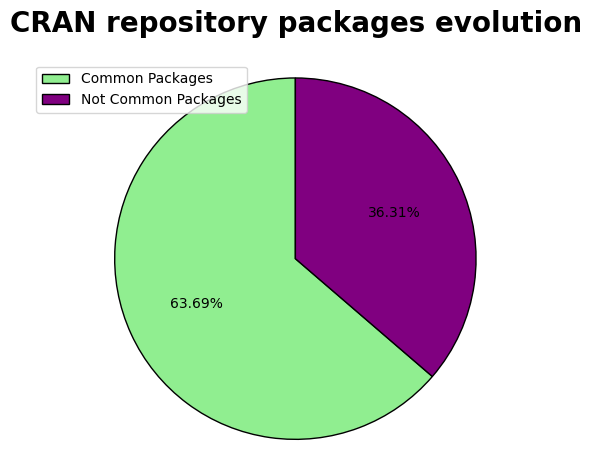

In [9]:
# Data for the graph
labels = ['Common Packages', 'Not Common Packages']
colors = ['lightgreen', 'purple']
sizes = [len(common_packages), len(list(set(scraping_packages) - set(libraiesio_packages)))]

# Customize the graph
fig, ax = plt.subplots()
ax.pie(sizes, autopct='%1.2f%%', startangle=90, colors=colors)
ax.set_aspect('equal')
ax.set_title(f'{REPO_NAME} repository packages evolution', fontsize=20, fontweight='bold', pad=20)

# add a black border to the pie

for pie_wedge in ax.patches:
    pie_wedge.set_edgecolor('black')

# Add legend
ax.legend(labels, loc='best')

# Improve aesthetics
plt.axis('equal')
plt.tight_layout()

# Display the graph
plt.show()

# Save the graph
fig.savefig(f'{OUT_IMG_DIR}/circ_common_packages.png')

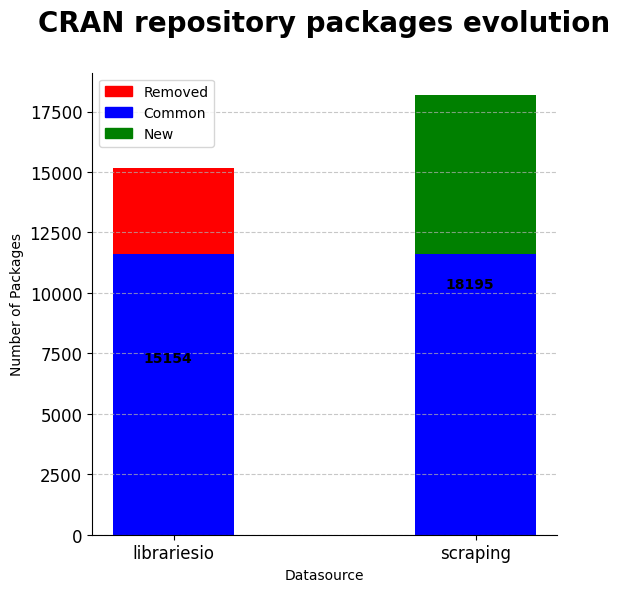

In [10]:
# Identifying common packages, exclusive to lista1, and exclusive to lista2
common_packages = list(set(libraiesio_packages) & set(scraping_packages))
new_packages = list(set(scraping_packages) - set(libraiesio_packages))
old_packages = list(set(libraiesio_packages) - set(scraping_packages))

# Configuring colors
colors_lista1 = ['red', 'blue']
colors_lista2 = ['green', 'blue']

# Heights of the bars
height_lista1 = len(libraiesio_packages)
height_lista2 = len(scraping_packages)

# Create the bar plot
fig, ax = plt.subplots(figsize=(6, 6))

# Bar for lista1
ax.bar('librariesio', height_lista1, color=colors_lista1, width=0.4)
ax.bar('librariesio', len(old_packages), color='red', width=0.4,)
ax.bar('librariesio', len(common_packages), color='blue', width=0.4)

# Bar for lista2
ax.bar('scraping', height_lista2, color=colors_lista2, width=0.4)
ax.bar('scraping', len(new_packages), color='green', width=0.4)
ax.bar('scraping', len(common_packages), color='blue', width=0.4)

# Configure titles and axis labels
ax.set_title(f'{REPO_NAME} repository packages evolution', fontsize=20, fontweight='bold', pad=30)
ax.set_xlabel('Datasource')
ax.set_ylabel('Number of Packages')

# Add labels to the sections of the bar chart
ax.text(-0.1, height_lista1 - 8000, str(height_lista1), color='black', fontweight='bold')
ax.text(0.9, height_lista2 - 8000, str(height_lista2), color='black', fontweight='bold')

# Add a horizontal grid
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Adjusting plot borders
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Adjusting tick labels font size
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)

# Configure legend
legend_labels = ['Removed', 'Common', 'New']
legend_handles = [plt.Rectangle((0, 0), 1, 1, color=color) for color in colors_lista1 + ['green']]
ax.legend(legend_handles, legend_labels)

# Show the bar plot
plt.show()

# Save the bar plot
fig.savefig(f'{OUT_IMG_DIR}/bar_common_packages.png')


### **Network analysis**

We construct the networks to perform the analysis, using a directed network (A --> B, where B is a direct dependency of A).

In [9]:
# Libraries.io graph
librariesio_G = build_dependency_network(
    df = librariesio_df,
    chunk_size = 100000,
    dependent_field = 'Project Name',
    dependency_field = 'Dependency Name',
)

# Scraped graph
scraped_G = build_dependency_network(
    df = scraped_df,
    chunk_size = 100000,
    dependent_field = 'name',
    dependency_field = 'dependency',
)

Using process  psutil.Process(pid=217117, name='python', status='running', started='17:39:20')
Initializing graph... OK
0.0M lines | 15647 nodes, 76207 deps. (0s) 173.5Mb
Done processing DataFrame
Using process  psutil.Process(pid=217117, name='python', status='running', started='17:39:20')
Initializing graph... OK
0.0M lines | 17135 nodes, 99997 deps. (0s) 218.4Mb
0.1M lines | 18671 nodes, 113273 deps. (0s) 221.9Mb
Done processing DataFrame


In [11]:
# NUmero de nodos
print("Number of nodes: ", librariesio_G.number_of_nodes())

# Numero de edges
print("Number of edges: ", librariesio_G.number_of_edges())

# grado medio
print("Average degree: ", sum(dict(librariesio_G.degree()).values())/librariesio_G.number_of_nodes())

# diametro
# print("Diameter: ", nx.diameter(scraped_G))

# clustering
print("Average clustering coefficient: ", nx.average_clustering(librariesio_G))

Number of nodes:  15647
Number of edges:  76207
Average degree:  9.740780980379625
Average clustering coefficient:  0.1315468753001686


In [10]:
# NUmero de nodos
print("Number of nodes: ", scraped_G.number_of_nodes())

# Numero de edges
print("Number of edges: ", scraped_G.number_of_edges())

# grado medio
print("Average degree: ", sum(dict(scraped_G.degree()).values())/scraped_G.number_of_nodes())

# diametro
# print("Diameter: ", nx.diameter(scraped_G))

# clustering
print("Average clustering coefficient: ", nx.average_clustering(scraped_G))

Number of nodes:  18671
Number of edges:  113273
Average degree:  12.133576134111724
Average clustering coefficient:  0.15274052420796844


In [12]:
# Libraries.io model
librariesio_model = OliviaNetwork()
librariesio_model.build_model(librariesio_G)

# Scraped based model
scraped_model = OliviaNetwork()
scraped_model.build_model(scraped_G)

Building Olivia Model
     Finding strongly connected components (SCCs)...
     Building condensation network...
     Adding structural meta-data...
     Done
Building Olivia Model
     Finding strongly connected components (SCCs)...
     Building condensation network...
     Adding structural meta-data...
     Done


#### **1 - Degree**

Regarding the degree distribution, no significant changes are observed.

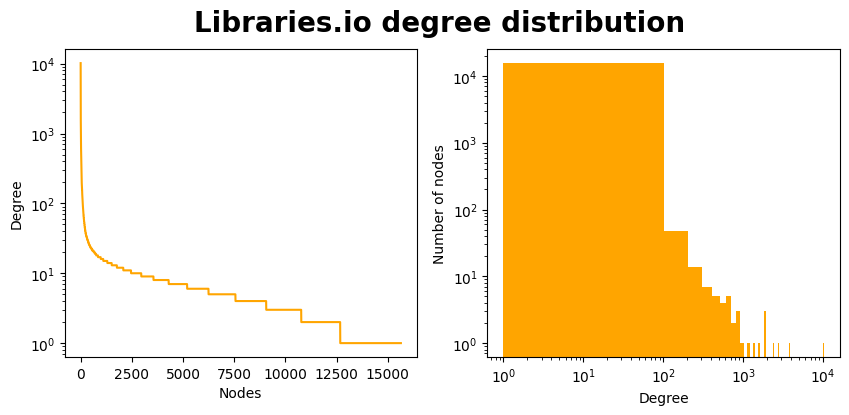

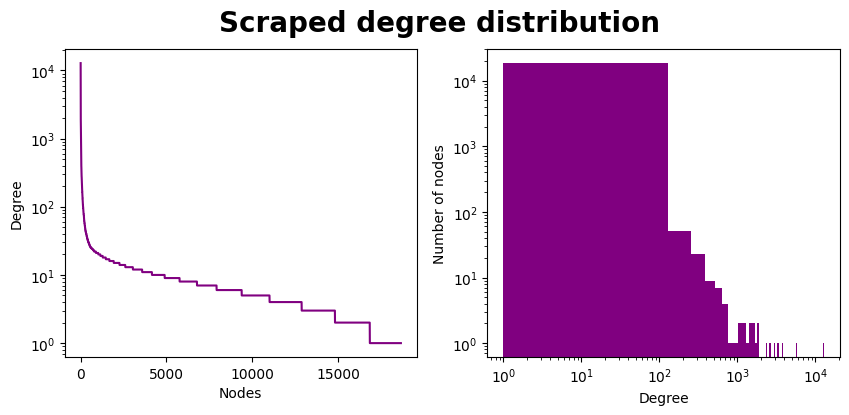

In [13]:
plot_degree_distribution(librariesio_G, 'Libraries.io degree distribution', "orange", save=True, filename=f'{OUT_IMG_DIR}/librariesio_degree_distribution.png')
plot_degree_distribution(scraped_G, 'Scraped degree distribution', "purple", save=True, filename=f'{OUT_IMG_DIR}/scraped_degree_distribution.png')

It can indeed be observed that there has been an increase in the average degree of the network during this evolution.

In [14]:
# Libraries.io graph average degree
print("Average degree of libraries.io graph: ", librariesio_G.number_of_edges() / librariesio_G.number_of_nodes())
# Scraped graph average degree
print("Average degree of scraped graph: ", scraped_G.number_of_edges() / scraped_G.number_of_nodes())



Average degree of libraries.io graph:  4.870390490189813
Average degree of scraped graph:  6.066788067055862


#### **2 - Out degree**

##### Evolution

Top out degree librariesio packages evolution

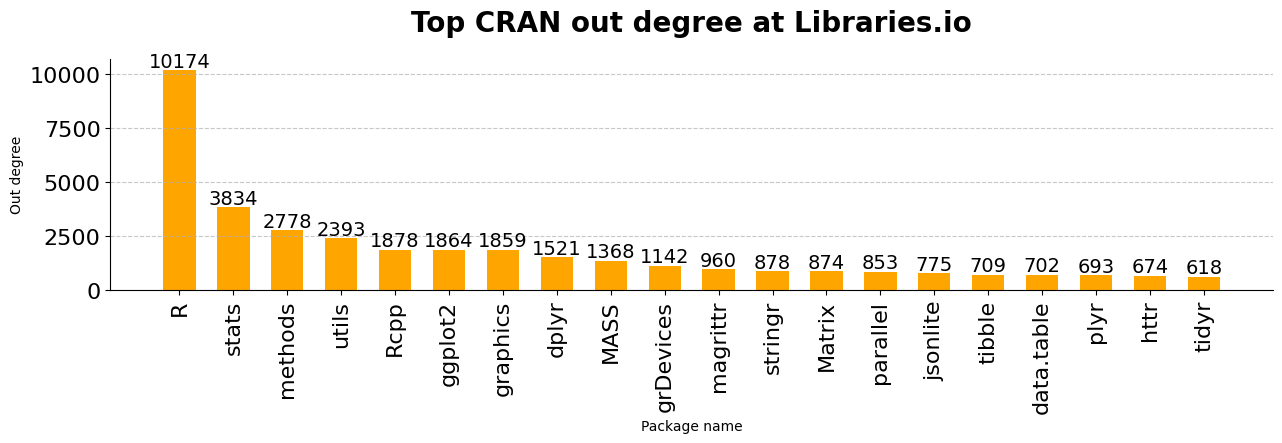

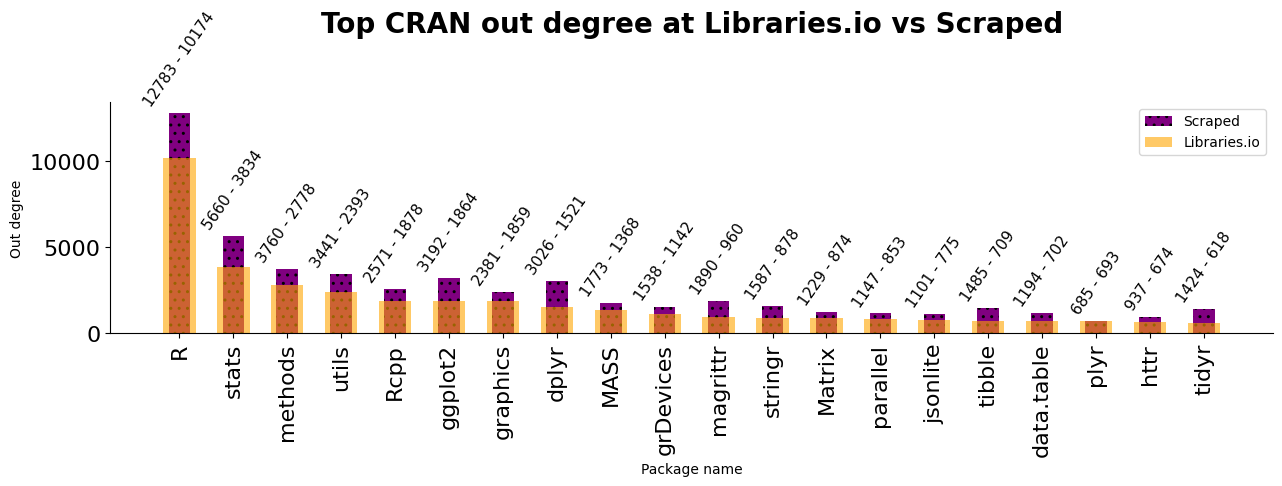

In [15]:
libio_t20_outd = sorted(librariesio_G.out_degree(), key=lambda x: x[1], reverse=True)[:20]

plot_dict(
    d = dict(libio_t20_outd),
    title = f'Top {REPO_NAME} out degree at Libraries.io',
    xlabel = 'Package name',
    ylabel = 'Out degree',
    rotation = 0,
    size = (15, 3),
    offset = 400,
    label_size = 16,
    font_size = 14,
    label_rotation = 90,
    w=0.6,
    save=True,
    filename=f'{OUT_IMG_DIR}/libio_t20_outd.png',
)


# Plot evolution of top (librariesio) out degree
# ------------------------------------------------
    
plot_comparison(
    ss = libio_t20_outd,
    tt_G = scraped_G,
    save=True,
    filename=f'{OUT_IMG_DIR}/libio_t20_outd_comparison.png',
    xticks_rotation=90,
    bar_offset=400,
    xticks_size=16,
    font_size=11,
    rotation=55,
    tittle=f'Top {REPO_NAME} out degree at Libraries.io vs Scraped',
    metric='Out degree',
    comparable=scraped_G.out_degree(),
)


In [16]:
# Tabla con la evolucion del componente fuertemente conectado para el top 20 de libio
# -----------------------------------------------------------------------------------

# Top 20 out degree packages at librariesio
libio_t20_outd = sorted(librariesio_G.out_degree(), key=lambda x: x[1], reverse=True)[:20]

# Define a dictionary to store the strongly connected components for each package
libio_t20_outd_scc = {}

# Add the strongly connected components to the dictionary
for package, out_degree in libio_t20_outd:
    libio_t20_outd_scc[package] = [len(librariesio_model[package].scc()), len(scraped_model[package].scc())]

# Create a dataframe with the strongly connected components
t20_outd_scc = pd.DataFrame.from_dict(libio_t20_outd_scc, orient='index', columns=['SCC libraries.io', 'SCC Scraped'])

t20_outd_scc



SCC libraries.io  SCC Scraped
R                          1            1
stats                      1            1
methods                    1            1
utils                      1            1
Rcpp                       1            1
ggplot2                    1            1
graphics                   1            1
dplyr                      1            1
MASS                       1            1
grDevices                  1            1
magrittr                   1            1
stringr                    1            1
Matrix                     1            1
parallel                   1            1
jsonlite                   1            1
tibble                     1            1
data.table                 1            1
plyr                       1            1
httr                       1            1
tidyr                      1            1

Top out degree scraped packages evolution

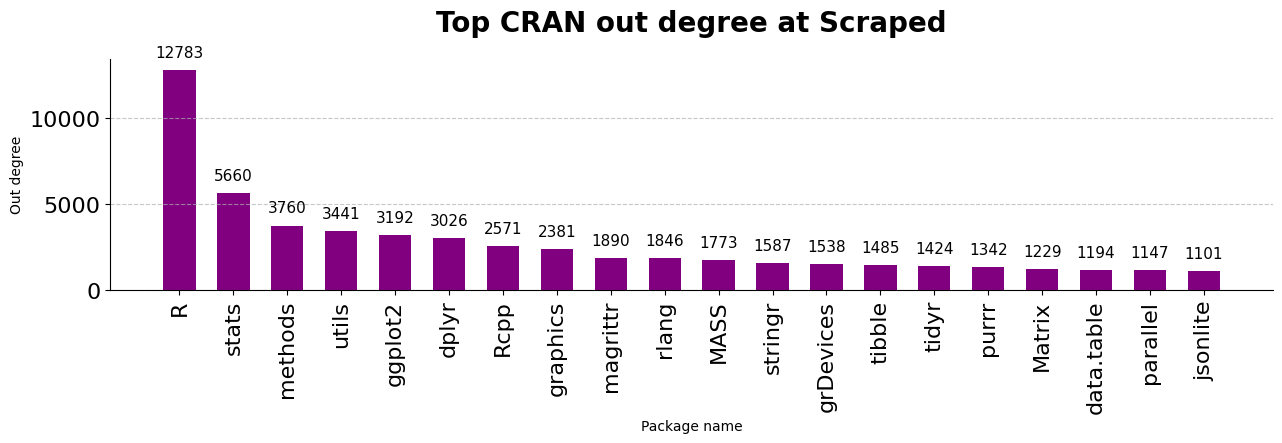

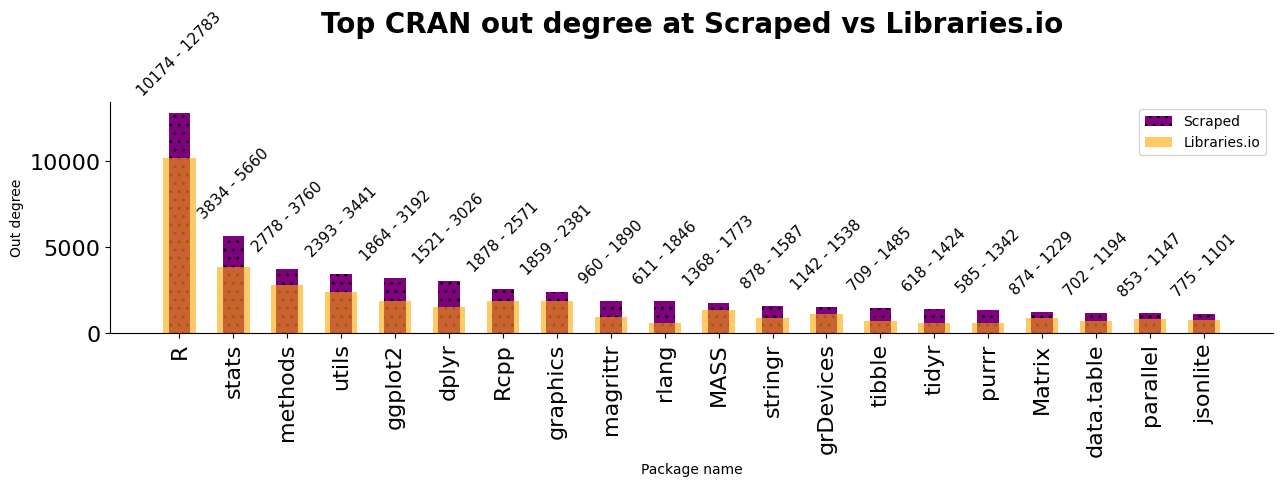

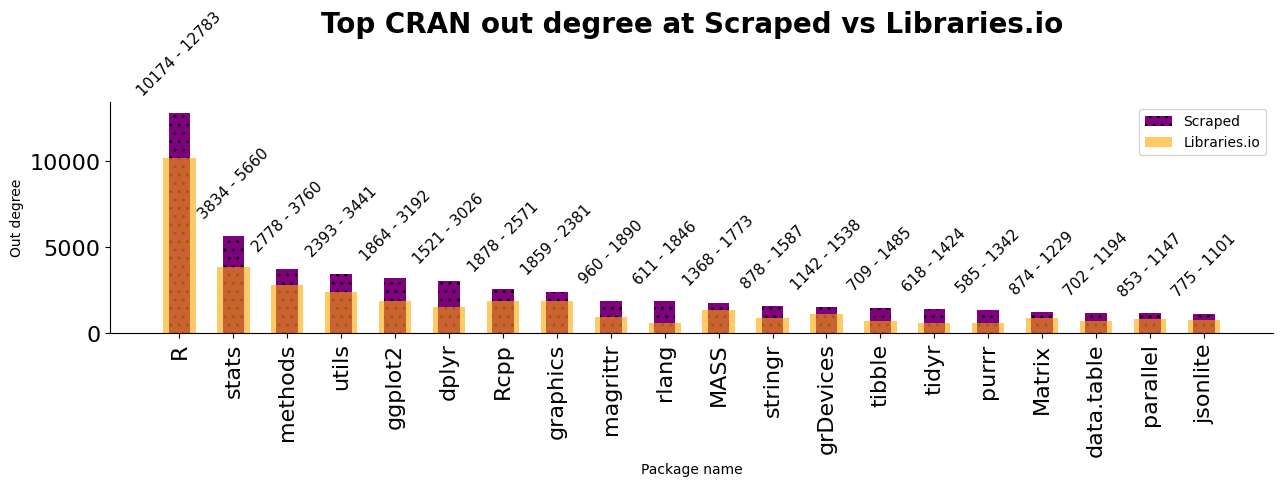

In [17]:
scraped_t20_outd = sorted(scraped_G.out_degree(), key=lambda x: x[1], reverse=True)[:20]

plot_dict(
    d = dict(scraped_t20_outd),
    title = f'Top {REPO_NAME} out degree at Scraped',
    xlabel = 'Package name',
    ylabel = 'Out degree',
    color='purple',
    rotation = 0,
    size = (15, 3),
    offset = 1000,
    label_size = 16,
    font_size = 11,
    label_rotation = 90,
    w=0.6,
    save=True,
    filename=f'{OUT_IMG_DIR}/scraped_t20_outd.png',
)


# Plot evolution of top (librariesio) out degree
# ------------------------------------------------

plot_comparison_reversed(
    ss = scraped_t20_outd,
    tt_G =librariesio_G,
    save=True,
    filename=f'{OUT_IMG_DIR}/scraped_t20_outd_comparison.png',
    xticks_rotation=90,
    bar_offset=1000,
    xticks_size=16,
    font_size=11,
    rotation=45,
    tittle=f'Top {REPO_NAME} out degree at Scraped vs Libraries.io',
    metric='Out degree',
    comparable=librariesio_G.out_degree(),
)


# Top out degree packages in scraped that are in librariesio
# ---------------------------------------------------------

top_outd_scraped = sorted(scraped_G.out_degree(), key=lambda x: x[1], reverse=True)

top_outd_scraped_in_libio = []
librariesio_nodes = list(librariesio_G.nodes())
for node in top_outd_scraped:
    
    # Check if node is in librariesio
    if node[0] in librariesio_nodes:
        top_outd_scraped_in_libio.append(node)

    if len(top_outd_scraped_in_libio) == 20:
        break


plot_comparison_reversed(
    ss = top_outd_scraped_in_libio,
    tt_G = librariesio_G,
    save=True,
    filename=f'{OUT_IMG_DIR}/libio_scraped_t20_comparation.png',
    xticks_rotation=90,
    bar_offset=1000,
    xticks_size=16,
    font_size=11,
    rotation=45,
    tittle=f'Top {REPO_NAME} out degree at Scraped vs Libraries.io',
    metric='Out degree',
    comparable=librariesio_G.out_degree(),
)


### Scraped SCC

SCC libraries.io  SCC Scraped
R                          1            1
stats                      1            1
methods                    1            1
utils                      1            1
ggplot2                    1            1
dplyr                      1            1
Rcpp                       1            1
graphics                   1            1
magrittr                   1            1
rlang                      1            1
MASS                       1            1
stringr                    1            1
grDevices                  1            1
tibble                     1            1
tidyr                      1            1
purrr                      1            1
Matrix                     1            1
data.table                 1            1
parallel                   1            1
jsonlite                   1            1

/tmp/ipykernel_103873/3509534842.py:73: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  axs[0].set_yscale('log')


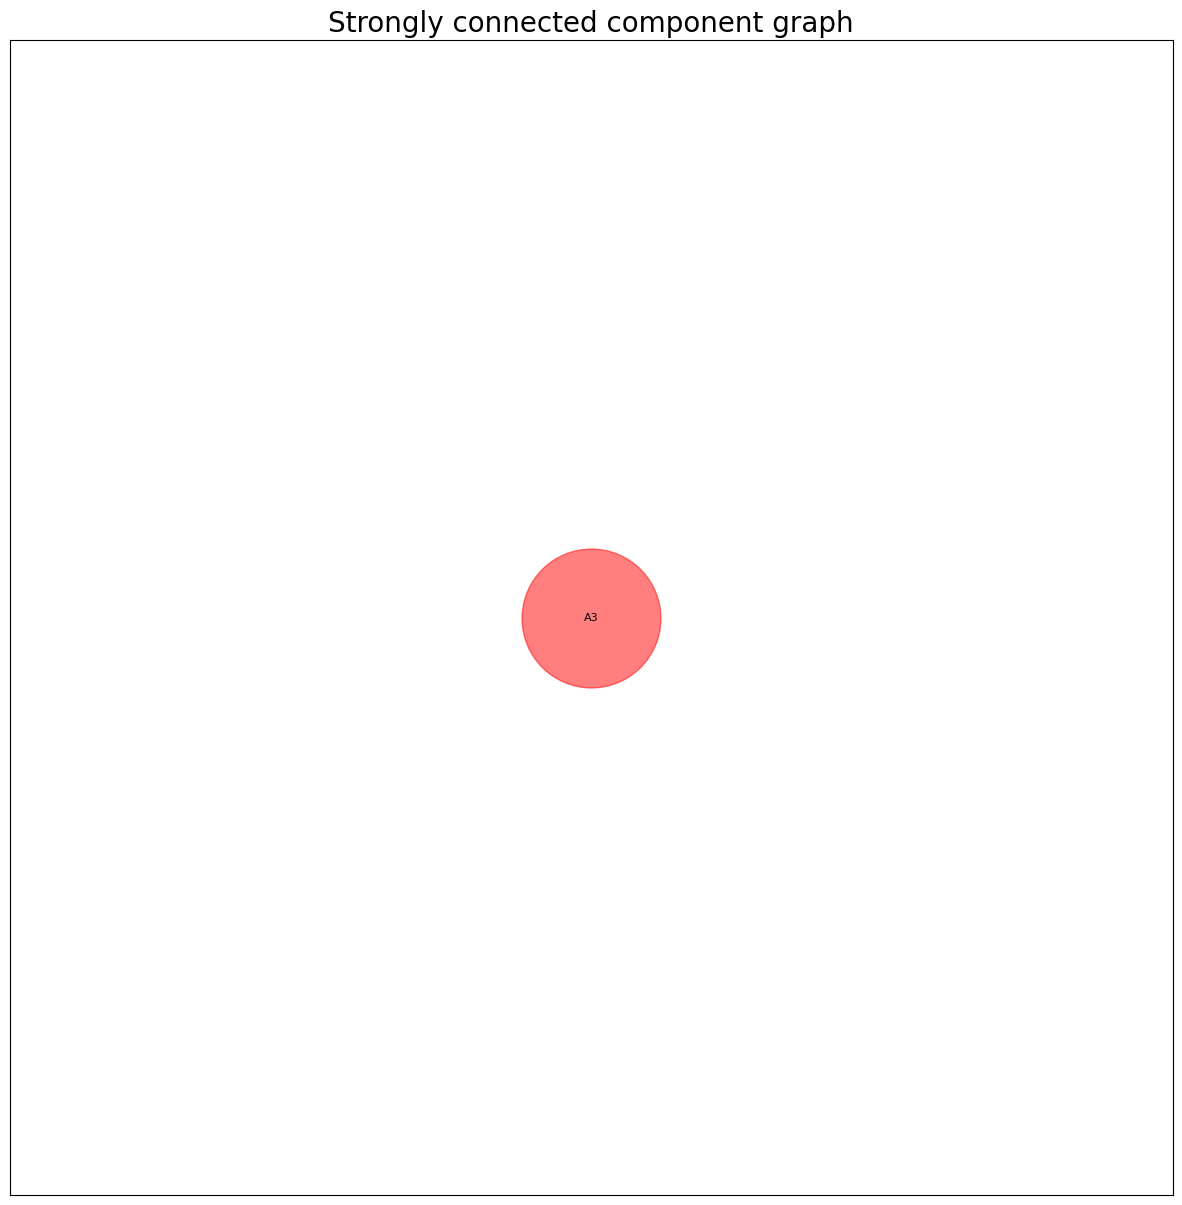

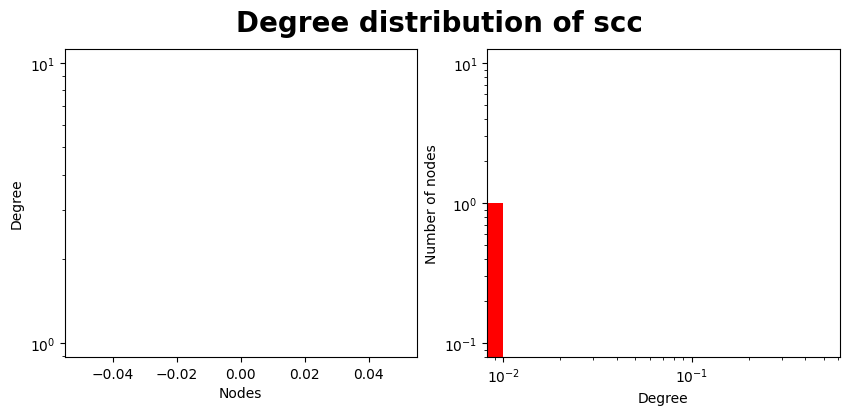

Average degree: 0.0
Density: 0
Diameter: 0
Clustering coefficient: 0.0


In [18]:
# Tabla con la evolucion del componente fuertemente conectado para el top 20 de scraped
# -----------------------------------------------------------------------------------

# Top 20 out degree packages at scraped
scraped_t20_outd = sorted(scraped_G.out_degree(), key=lambda x: x[1], reverse=True)[:20]

# Define a dictionary to store the strongly connected components for each package
scraped_t20_outd_scc = {}

# Add the strongly connected components to the dictionary
for package, out_degree in scraped_t20_outd:
    try:
        scraped_t20_outd_scc[package] = [len(librariesio_model[package].scc()), len(scraped_model[package].scc())]
    except:
        scraped_t20_outd_scc[package] = [None, len(scraped_model[package].scc())]

# Create a dataframe with the strongly connected components
t20_outd_scc = pd.DataFrame.from_dict(scraped_t20_outd_scc, orient='index', columns=['SCC libraries.io', 'SCC Scraped'])

display(t20_outd_scc)


# Dibujar el grafo de la componente fuertemente conectada de un paquete
# ---------------------------------------------------------------------

# Plot the strongly connected component
plt.figure(figsize=(15, 15))
plt.title('Strongly connected component graph', fontsize=20)

top_scc  = scraped_model.sorted_clusters()[0]


# Get edges from the strongly connected component
edges = []
for node in top_scc:
    for node2 in top_scc:
        if node != node2:
            if scraped_G.has_edge(node, node2):
                edges.append((node, node2))

# Create the graph
G = nx.DiGraph()
G.add_nodes_from(top_scc)
G.add_edges_from(edges)

# Tamaño de los nodos en funcion del grado de salida
# --------------------------------------------------

# Get the out degree of each node
pr = dict(nx.pagerank(G))

# Get the size of each node
node_size = []
for node in top_scc:
    node_size.append(pr[node] * 10000)




# Draw the graph in circular layout
pos = nx.kamada_kawai_layout(G)
nx.draw_networkx_nodes(G, pos, node_size=node_size, node_color='red', alpha=0.5)
nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.2)
nx.draw_networkx_labels(G, pos, font_size=8, font_color='black')


# Distribucion de los grados de los nodos
# ---------------------------------------

# Plot the degree distribution
plot_degree_distribution(
    G = G,
    save=True,
    filename=f'{OUT_IMG_DIR}/degree_distribution_scc.png',
    title=f'Degree distribution of scc',
    color='red'
)

# Grado medio de los nodos
# ------------------------

# Get the average degree
avg_degree = sum([d for n, d in G.degree()]) / len(G.nodes())

print(f'Average degree: {avg_degree}')

# Densidad de la red
# ------------------

# Get the density of the graph
density = nx.density(G)

print(f'Density: {density}')

# Diametro de la red
# ------------------

# Get the diameter of the graph
diameter = nx.diameter(G)

print(f'Diameter: {diameter}')

# Coeficiente de clustering
# -------------------------

# Get the clustering coefficient
clustering_coefficient = nx.average_clustering(G)

print(f'Clustering coefficient: {clustering_coefficient}')



In [19]:
# Obtener el top20 de componentes fuertemente conectados de scraped
# -----------------------------------------------------------------

# Get the top 20 strongly connected components
top_scc = scraped_model.sorted_clusters()[:20]

# Create a dataframe to store the strongly connected components
top_scc_df = pd.DataFrame(columns=[
    'Size', 
    'Head',
    'Head pagerank',
    'Avg degree',
    'Density', 
    'Diameter', 
    'Clustering coefficient', 
    'Transitive dependencies'
    ]
)

# Crear un grafo con cada componente fuertemente conectado
# --------------------------------------------------------

# Create a graph for each strongly connected component
for i, scc in enumerate(top_scc):
    G = nx.DiGraph()
    
    edges = []
    for node in scc:
        for node2 in scc:
            if node != node2:
                if scraped_G.has_edge(node, node2):
                    edges.append((node, node2))

    nodes = [node for node in scc]

    G.add_nodes_from(nodes)
    G.add_edges_from(edges)

    

    # Get the density of the graph
    density = nx.density(G)

    # Get the diameter of the graph
    diameter = nx.diameter(G)

    # Get the clustering coefficient
    clustering_coefficient = nx.average_clustering(G)

    # Get the sum of transitive dependencies for each node
    sum_transitive_dependencies = 0
    for node in scc:
        sum_transitive_dependencies += len(scraped_model[node].transitive_dependencies())

    # Top pagerank of nodes
    pr = dict(nx.pagerank(G.reverse()))
    pr = sorted(pr.items(), key=lambda x: x[1], reverse=True)[0]
    head = pr[0]

    # Get the average degree
    avg_degree = sum([d for n, d in G.degree()]) / len(G.nodes())

    # Add the strongly connected component to the dataframe
    top_scc_df.loc[i] = [
        len(scc),
        head,
        pr[1],
        avg_degree,
        density,
        diameter,
        clustering_coefficient,
        sum_transitive_dependencies
    ]

# Mostrar el top20 de componentes fuertemente conectados de scraped
# -----------------------------------------------------------------

display(top_scc_df)

Size         Head  Head pagerank  Avg degree Density Diameter  \
0     1           A3            1.0         0.0       0        0   
1     1     AATtools            1.0         0.0       0        0   
2     1       ABACUS            1.0         0.0       0        0   
3     1      ABC.RAP            1.0         0.0       0        0   
4     1     EDOtrans            1.0         0.0       0        0   
5     1  ABCanalysis            1.0         0.0       0        0   
6     1    ABSurvTDC            1.0         0.0       0        0   
7     1          ACA            1.0         0.0       0        0   
8     1         ACDC            1.0         0.0       0        0   
9     1     eNchange            1.0         0.0       0        0   
10    1         ACDm            1.0         0.0       0        0   
11    1         ACEP            1.0         0.0       0        0   
12    1         ACEt            1.0         0.0       0        0   
13    1         ACNE            1.0         0.0       0        0   
14    1        ACTCD            1.0         0.0       0        0   
15    1         ACWR            1.0         0.0       0        0   
16    1      scMappR            1.0         0.0       0        0   
17    1       ADAPTS            1.0         0.0       0        0   
18    1         ADER            1.0         0.0       0        0   
19    1        ADMUR            1.0         0.0       0        0   

    Clustering coefficient Transitive dependencies  
0                      0.0                       6  
1                      0.0                      27  
2                      0.0                      61  
3                      0.0                       4  
4                      0.0                     131  
5                      0.0                       6  
6                      0.0                      25  
7                      0.0                       5  
8                      0.0                      47  
9                      0.0                      51  
10                     0.0                      45  
11                     0.0                      13  
12                     0.0                       9  
13                     0.0                      34  
14                     0.0                      70  
15                     0.0                      39  
16                     0.0                     176  
17                     0.0                      53  
18                     0.0                       1  
19                     0.0                      22

###### Top out degree scraped packages evolution

##### Global out degree distribution

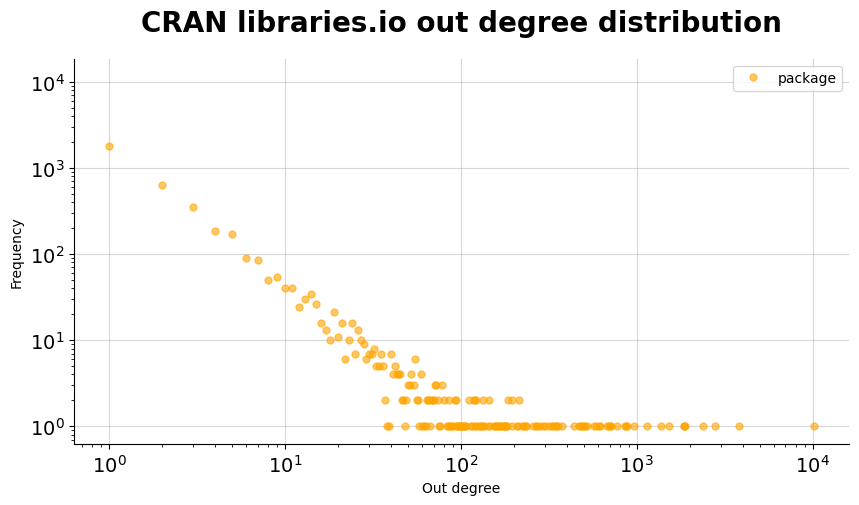

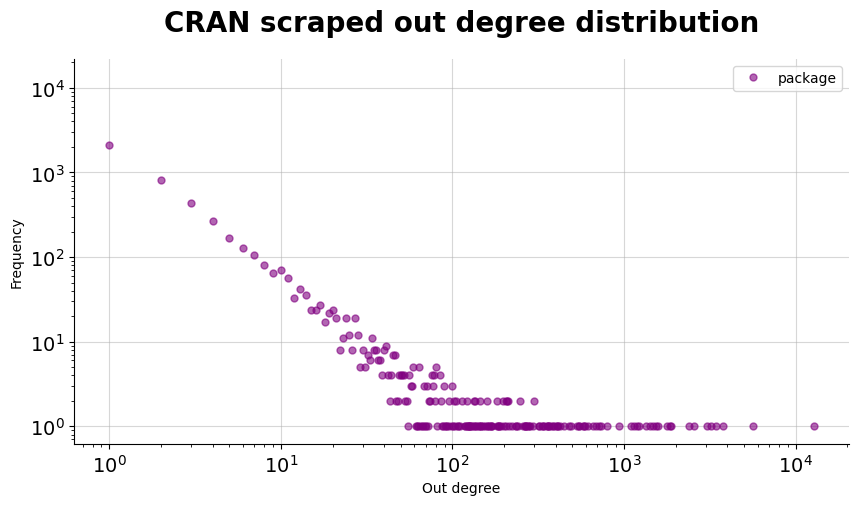

In [20]:
plot_data(
    data = [x[1] for x in librariesio_G.out_degree()],
    metric='Out degree',
    title=f'{REPO_NAME} libraries.io out degree distribution',
    color="orange"
)

plot_data(
    data = [x[1] for x in scraped_G.out_degree()],
    metric='Out degree',
    title=f'{REPO_NAME} scraped out degree distribution',
    color="purple"
)

#### **3 - In degree**

##### Evolution

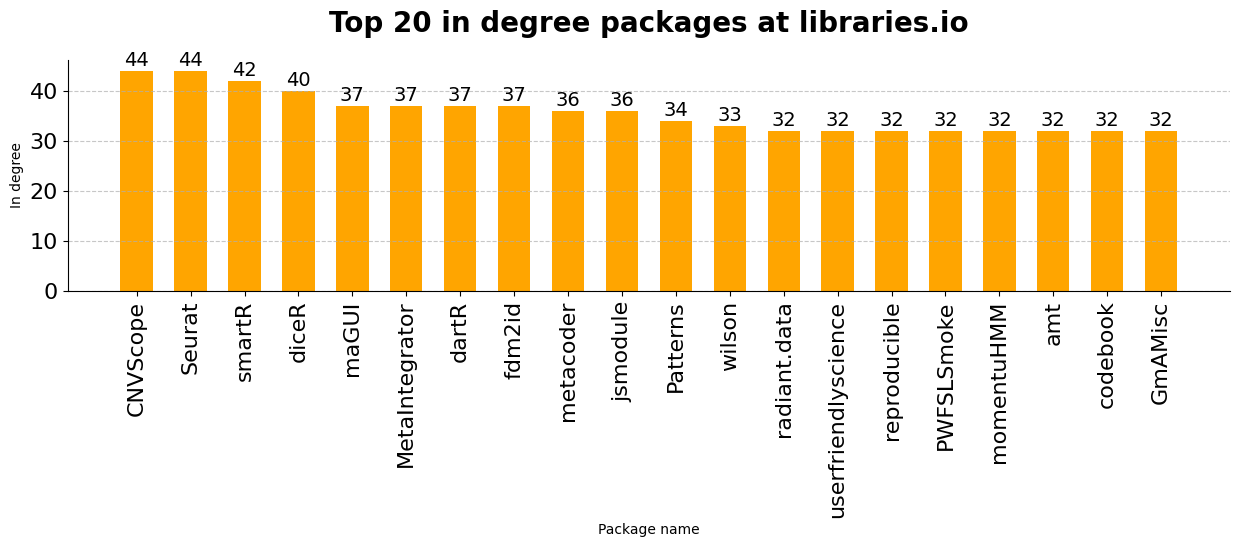

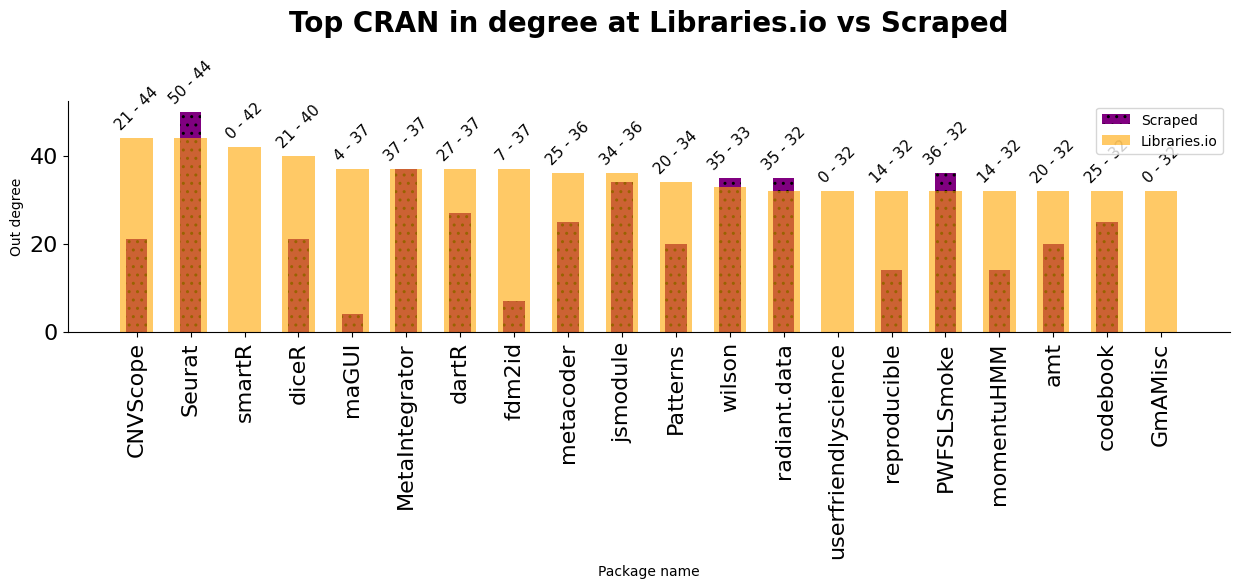

In [21]:
# Top 10 in degree (libraries.io and scraped input metrics)
# --------------------

libio_t20_ind = sorted(librariesio_G.in_degree(), key=lambda x: x[1], reverse=True)[:20]

plot_dict(
    d = dict(libio_t20_ind),
    title = 'Top 20 in degree packages at libraries.io',
    xlabel = 'Package name',
    ylabel = 'In degree',
    rotation = 0,
    size = (15, 3),
    offset = 2,
    label_size = 16,
    font_size = 14,
    label_rotation = 90,
    w=0.6
)

plot_comparison(
    ss = libio_t20_ind,
    tt_G = scraped_G,
    save=True,
    filename=f'{OUT_IMG_DIR}/libio_t20_ind_comparison.png',
    xticks_rotation=90,
    bar_offset=2,
    xticks_size=16,
    font_size=11,
    rotation=45,
    tittle=f'Top {REPO_NAME} in degree at Libraries.io vs Scraped',
    metric='Out degree',
    comparable=scraped_G.in_degree(),
)


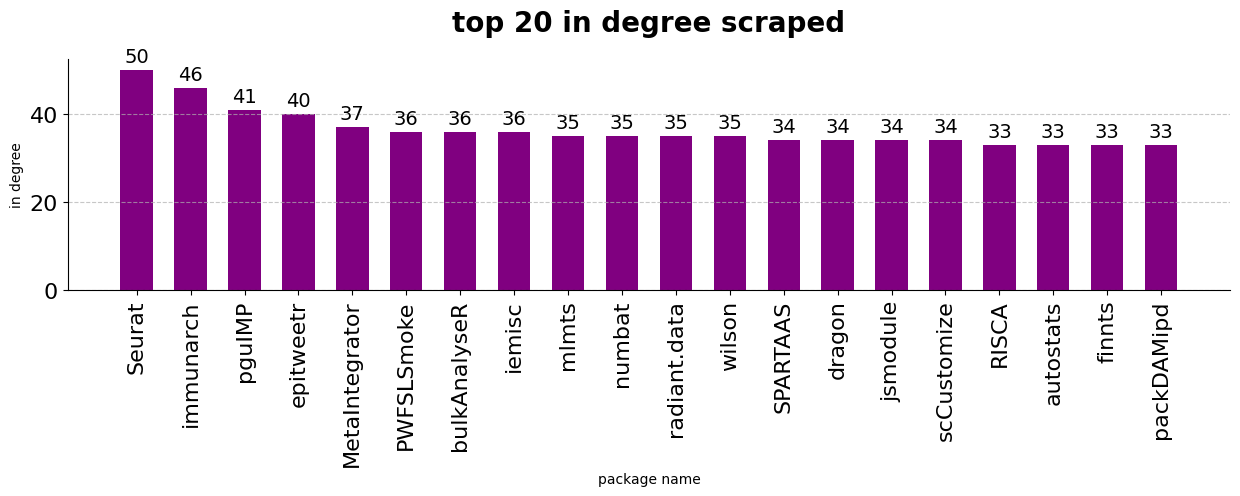

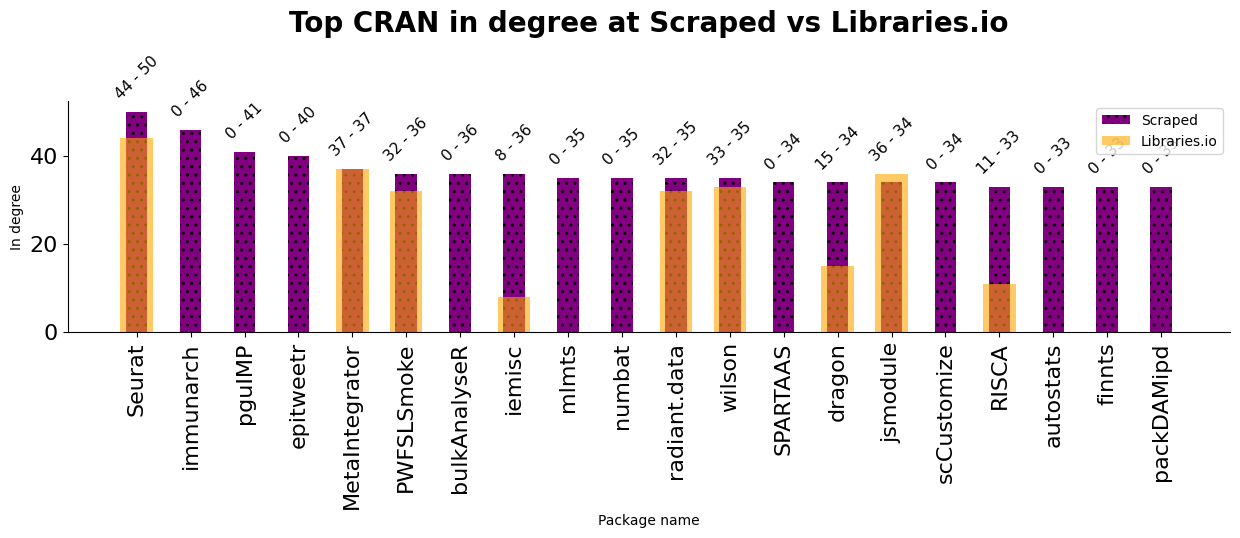

In [22]:
scraped_t20_ind = sorted(scraped_G.in_degree(), key=lambda x: x[1], reverse=True)[:20]

plot_dict(
    d = dict(scraped_t20_ind),
    title = 'top 20 in degree scraped',
    xlabel = 'package name',
    ylabel = 'in degree',
    rotation = 0,
    size = (15, 3),
    offset = 3,
    label_size = 16,
    font_size = 14,
    label_rotation = 90,
    color = 'purple',
    w=0.6
)

plot_comparison_reversed(
    ss = scraped_t20_ind,
    tt_G =librariesio_G,
    save=True,
    filename=f'{OUT_IMG_DIR}/scraped_t20_ind_comparison.png',
    xticks_rotation=90,
    bar_offset=3,
    xticks_size=16,
    font_size=11,
    rotation=45,
    tittle=f'Top {REPO_NAME} in degree at Scraped vs Libraries.io',
    metric='In degree',
    comparable=librariesio_G.in_degree(),
)

##### Global in degree distribution

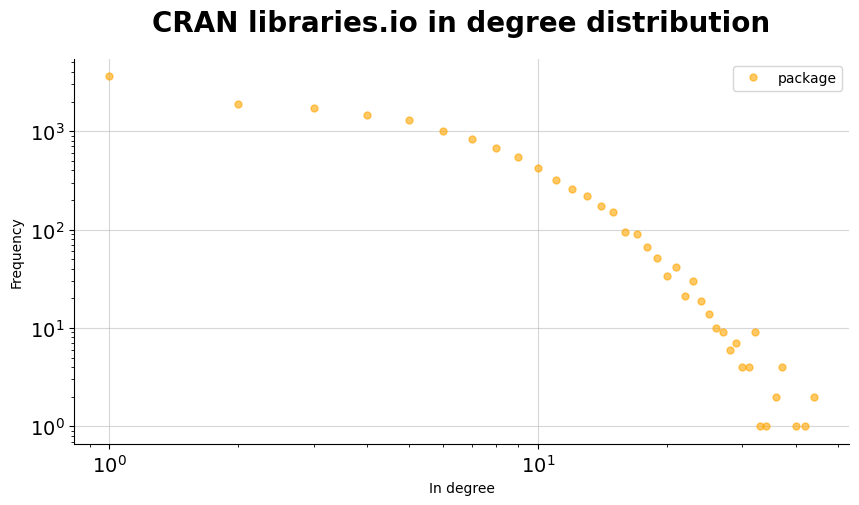

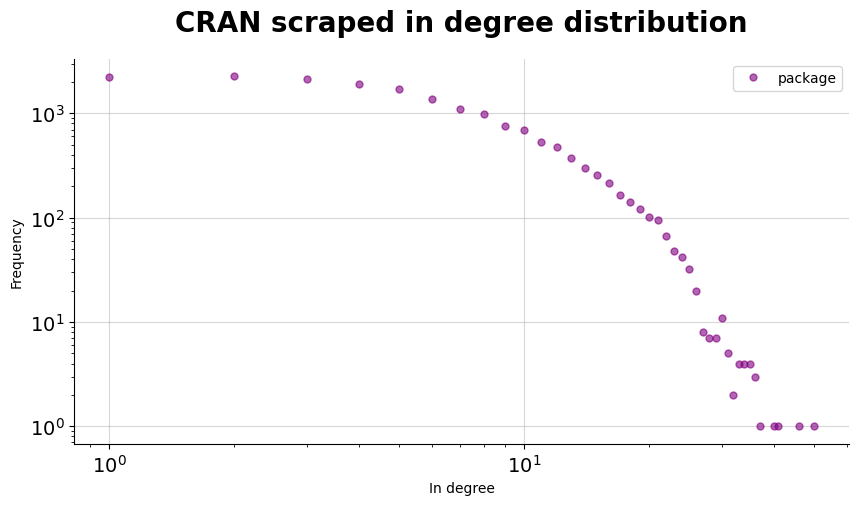

In [23]:

libio_in_degree = [x[1] for x in librariesio_G.in_degree()]
plot_data(libio_in_degree, 'In degree', f'{REPO_NAME} libraries.io in degree distribution', 'orange')

scraped_in_degree = [x[1] for x in scraped_G.in_degree()]
plot_data(scraped_in_degree, 'In degree', f'{REPO_NAME} scraped in degree distribution', 'purple')

#### **4 - Pagerrank**

##### Evolution

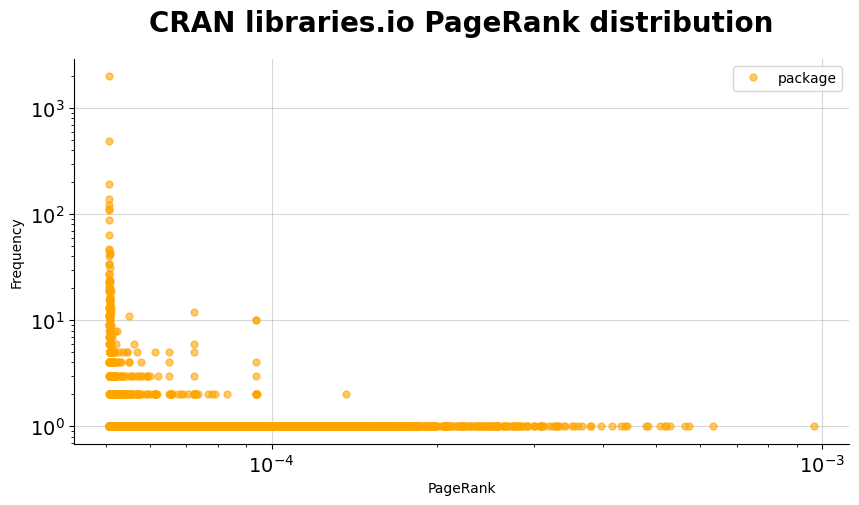

In [24]:
libio_pagerank = list(dict(nx.pagerank(librariesio_G)).values())

plot_data(
    libio_pagerank,
    'PageRank',
    f'{REPO_NAME} libraries.io PageRank distribution',
    'orange'
)


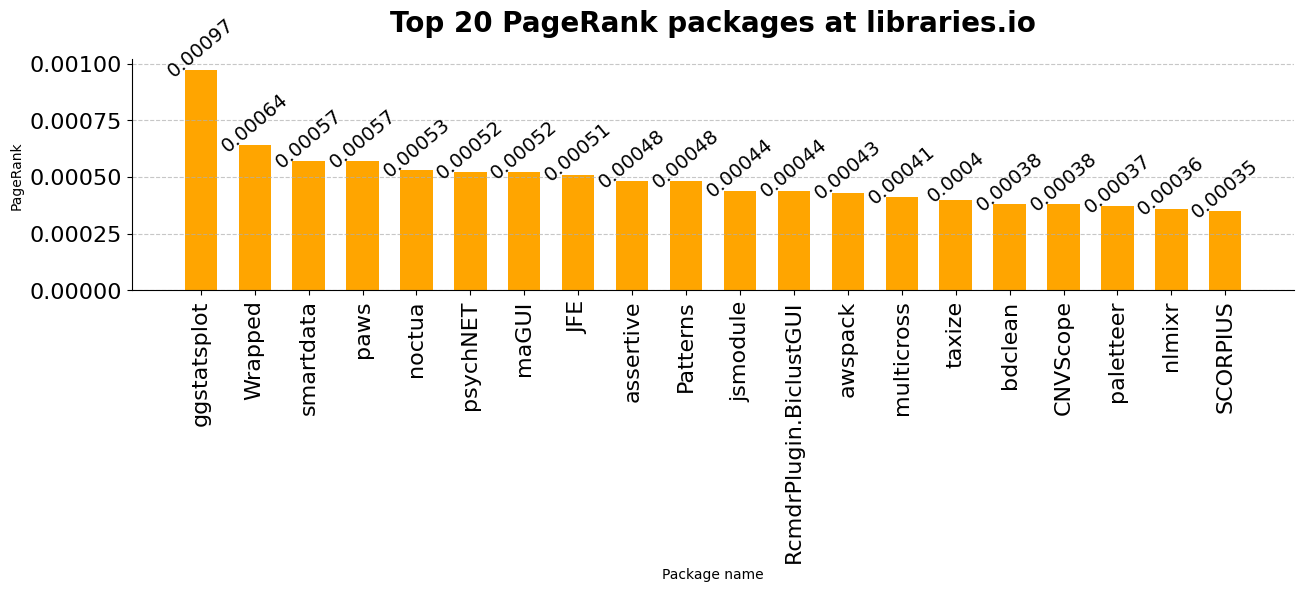

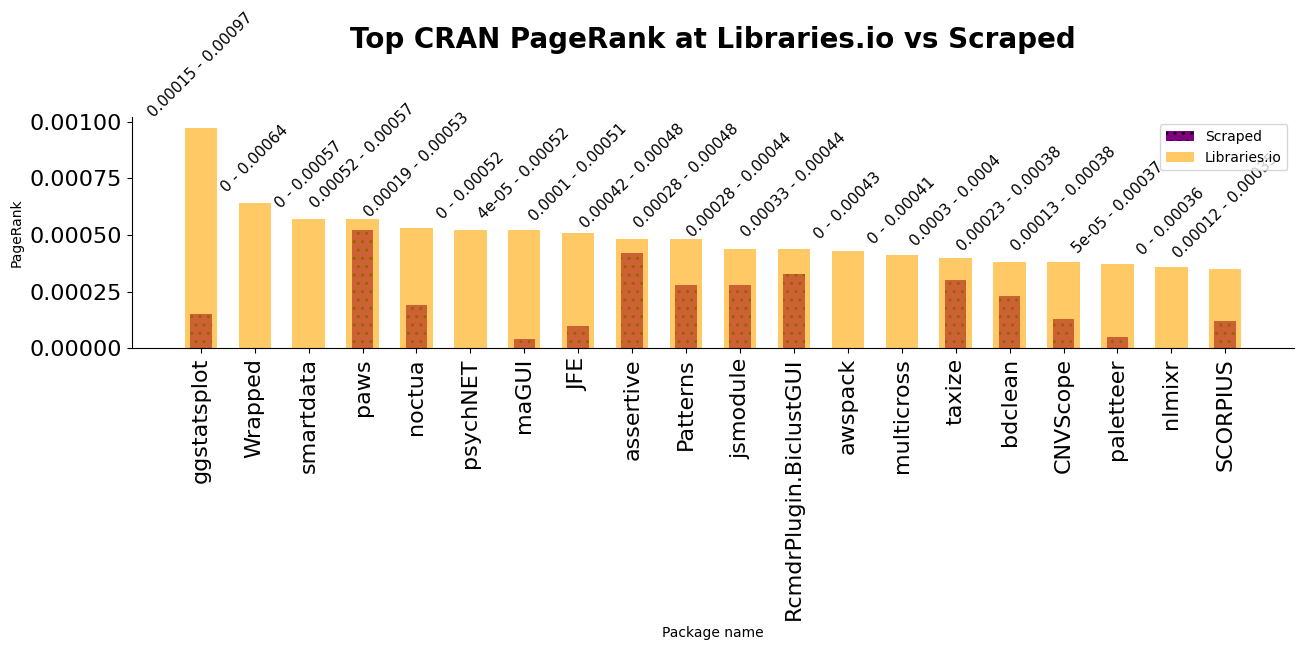

In [25]:
# Top 20 PageRank 
# ---------------

libio_t20_pr = sorted(nx.pagerank(librariesio_G).items(), key=lambda x: x[1], reverse=True)[:20]
libio_t20_pr = [(x[0], round(x[1], 5)) for x in libio_t20_pr]

plot_dict(
    d = dict(libio_t20_pr),
    title = 'Top 20 PageRank packages at libraries.io',
    xlabel = 'Package name',
    ylabel = 'PageRank',
    rotation = 40,
    size = (15, 3),
    offset = 0.0001,
    label_size = 16,
    font_size = 14,
    label_rotation = 90,
    w=0.6
)


pr = nx.pagerank(scraped_G)
pr = {k: round(v, 5) for k, v in pr.items()}

plot_comparison(
    ss = libio_t20_pr,
    tt_G = scraped_G,
    save=True,
    filename=f'{OUT_IMG_DIR}/libio_t20_pr_comparison.png',
    xticks_rotation=90,
    bar_offset=0.00005,
    xticks_size=16,
    font_size=11,
    rotation=45,
    tittle=f'Top {REPO_NAME} PageRank at Libraries.io vs Scraped',
    metric='PageRank',
    comparable=pr
)

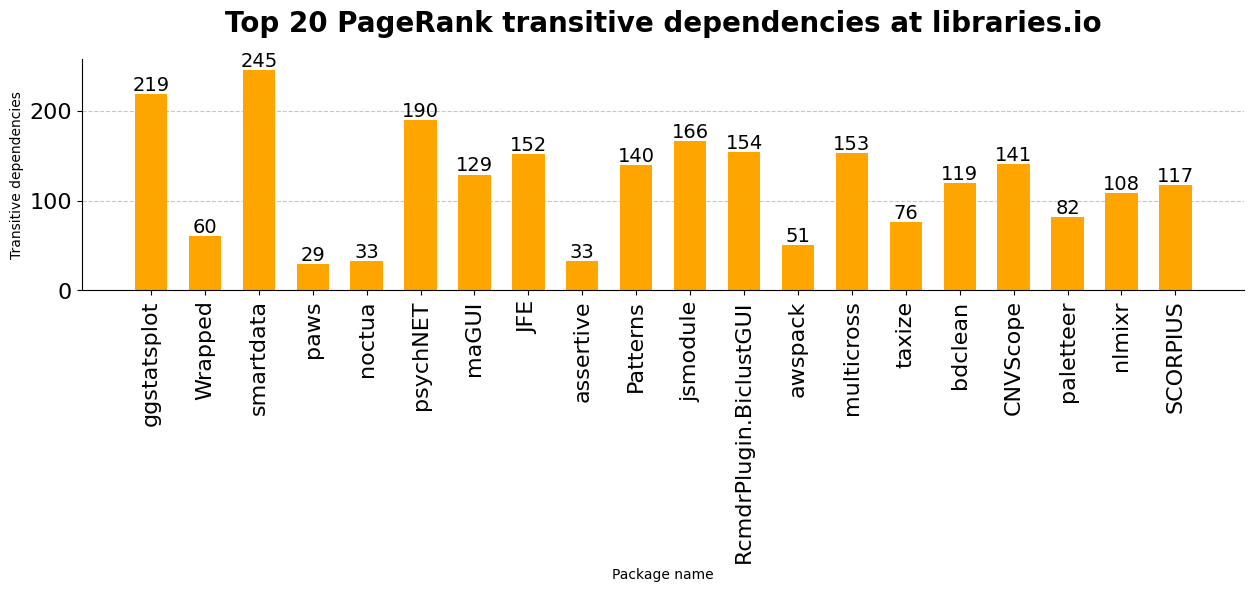

In [26]:
# Top 20 PageRank transitive dependencies at libraries.io
# -------------------------------------------------------


keys = [x[0] for x in libio_t20_pr]

# get transitive dependencies for each package
transitive_dependencies = {}
for k in keys:

    len_k = len(librariesio_model[k].transitive_dependencies())
    transitive_dependencies[k] = len_k


plot_dict(
    d = transitive_dependencies,
    title = 'Top 20 PageRank transitive dependencies at libraries.io',
    xlabel = 'Package name',
    ylabel = 'Transitive dependencies',
    rotation = 0,
    offset=10,
    size = (15, 3),
    label_size = 16,
    font_size = 14,
    label_rotation = 90,
    w=0.6
)

    

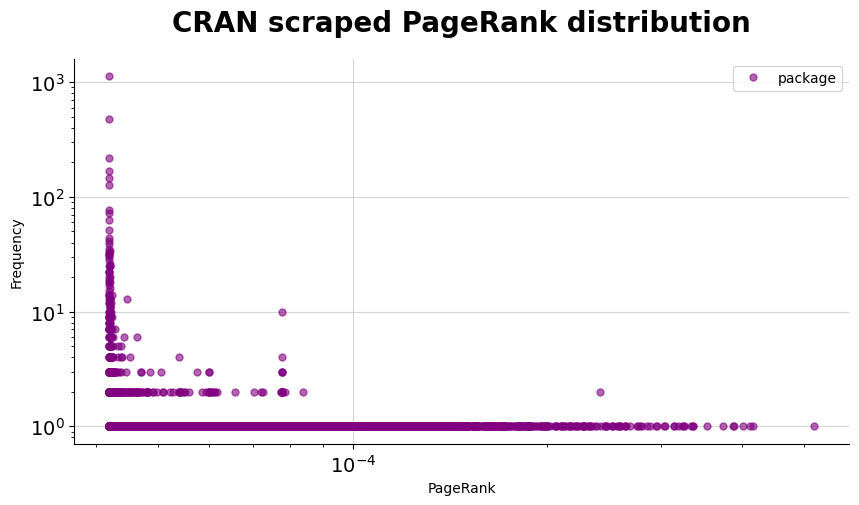

In [27]:
# Pagerank distribution
# ---------------------

# Libraries.io
scraped_pagerank = list(dict(nx.pagerank(scraped_G)).values())
plot_data(scraped_pagerank, 'PageRank', f'{REPO_NAME} scraped PageRank distribution', 'purple')

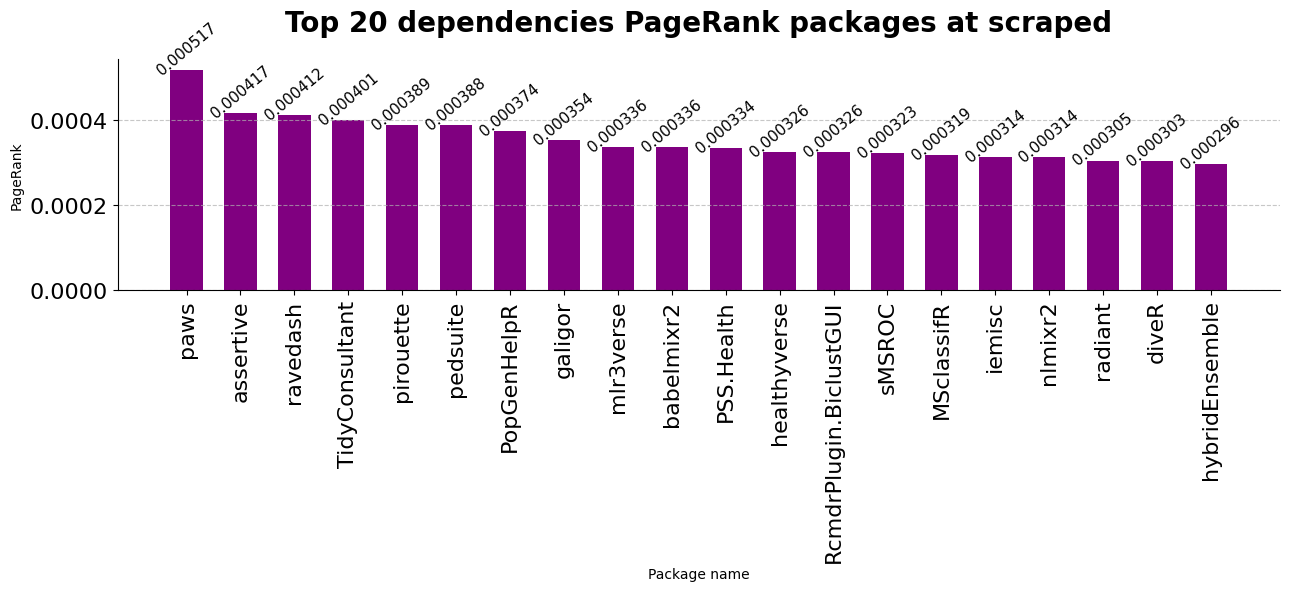

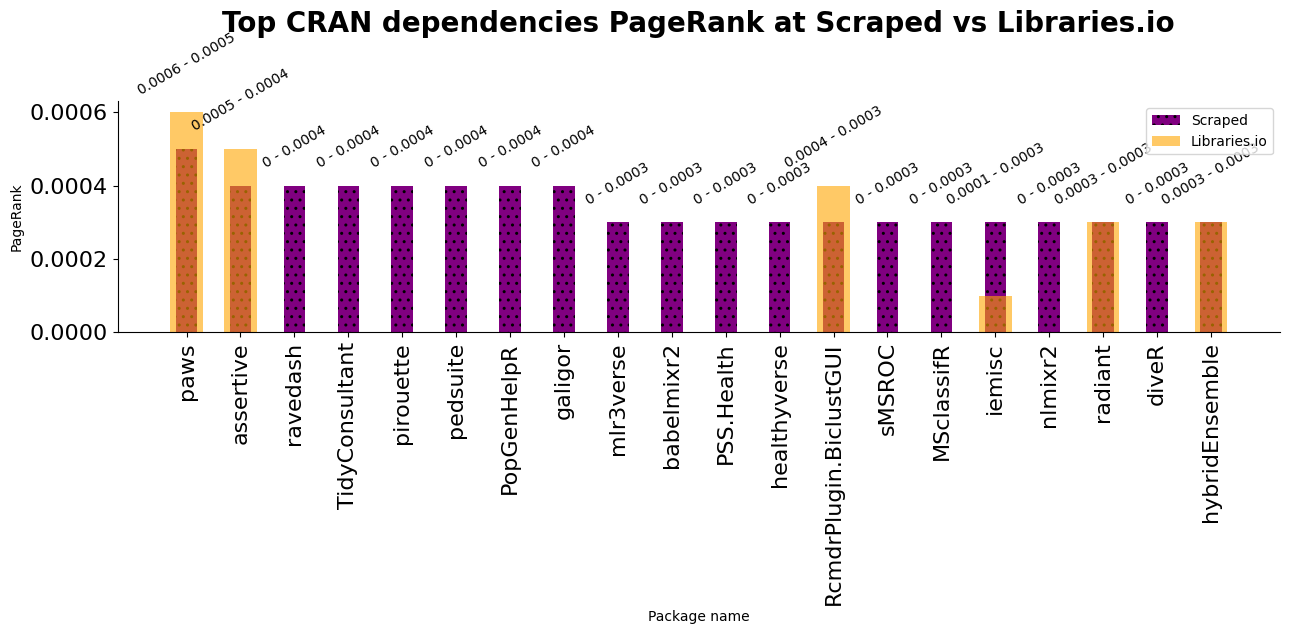

In [83]:
scraped_t20_pr = sorted(nx.pagerank(scraped_G).items(), key=lambda x: x[1], reverse=True)[:20]
scraped_t20_pr = [(x[0], round(x[1], 6)) for x in scraped_t20_pr]

plot_dict(
    d = dict(scraped_t20_pr),
    title = 'Top 20 dependencies PageRank packages at scraped',
    xlabel = 'Package name',
    ylabel = 'PageRank',
    rotation = 40,
    size = (15, 3),
    offset = 0.00005,
    label_size = 16,
    font_size = 11,
    label_rotation = 90,
    w=0.6,
    color='purple'
)


# Plot evolution of top PageRank scraped packages
# ---------------------------------------------------

# Get PageRank of each node of top PageRank scraped using the libraries.io graph
pr = nx.pagerank(librariesio_G)

scraped_t20_pr_rounded = [(x[0], round(x[1], 4)) for x in scraped_t20_pr]

plot_comparison_reversed(
    ss = scraped_t20_pr_rounded,
    tt_G = librariesio_G,
    save=True,
    filename=f'{OUT_IMG_DIR}/scraped_t20_pr_comparison.png',
    xticks_rotation=90,
    bar_offset=0.00005,
    xticks_size=16,
    font_size=10,
    rotation=30,
    tittle=f'Top {REPO_NAME} dependencies PageRank at Scraped vs Libraries.io',
    metric='PageRank',
    comparable={k: round(v, 4) for k, v in pr.items()}
)



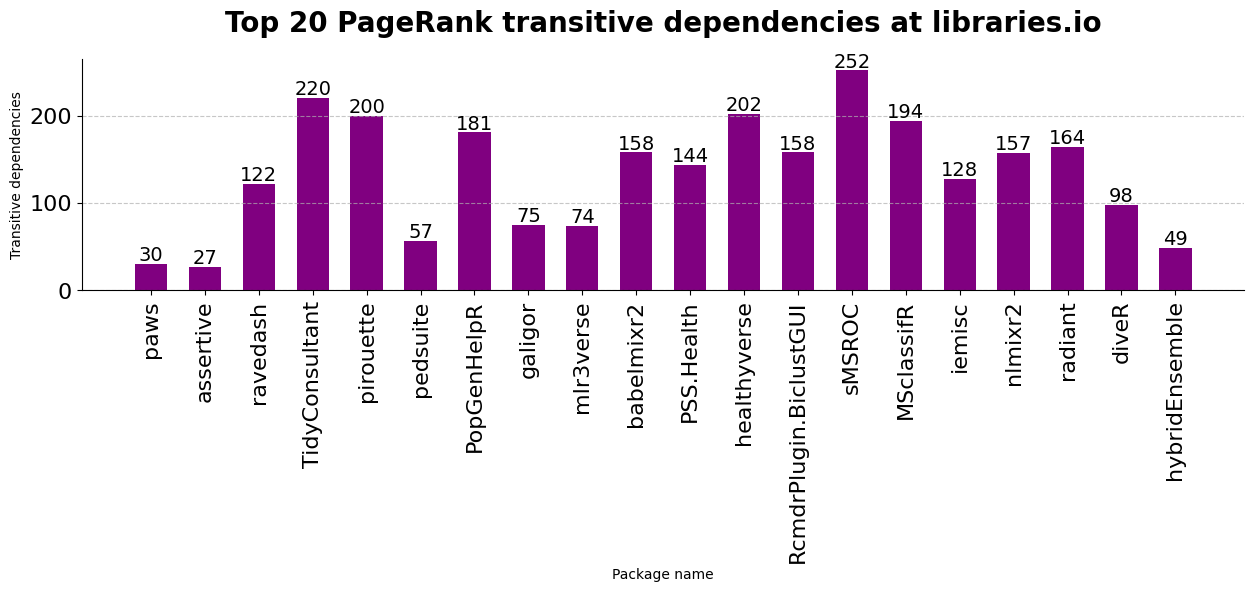

In [85]:
# Top 20 PageRank transitive dependencies at libraries.io
# -------------------------------------------------------


keys = [x[0] for x in scraped_t20_pr]

# get transitive dependencies for each package
transitive_dependencies = {}
for k in keys:

    len_k = len(scraped_model[k].transitive_dependencies())
    transitive_dependencies[k] = len_k


plot_dict(
    d = transitive_dependencies,
    title = 'Top 20 PageRank transitive dependencies at libraries.io',
    xlabel = 'Package name',
    ylabel = 'Transitive dependencies',
    rotation = 0,
    offset=10,
    size = (15, 3),
    label_size = 16,
    font_size = 14,
    label_rotation = 90,
    w=0.6,
    color='purple'
)

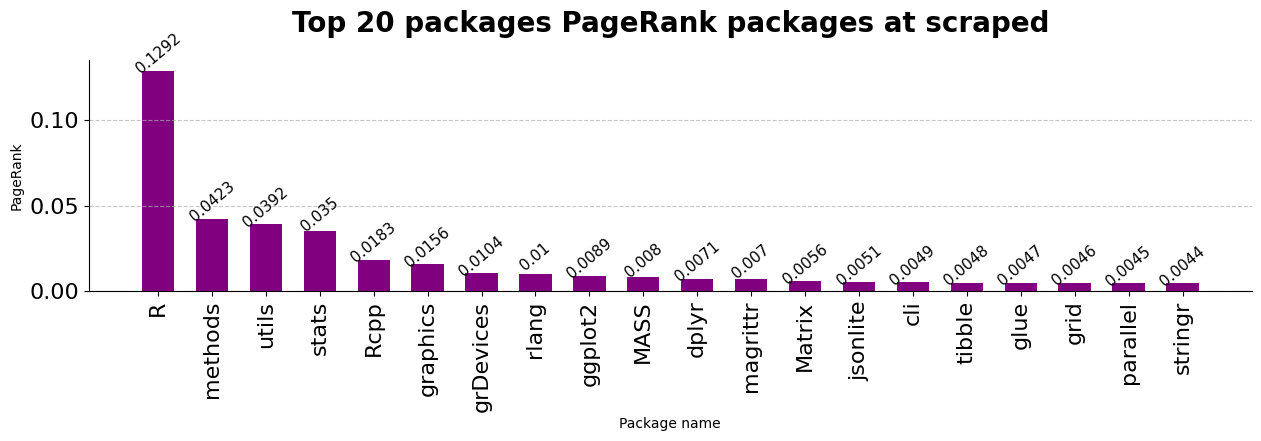

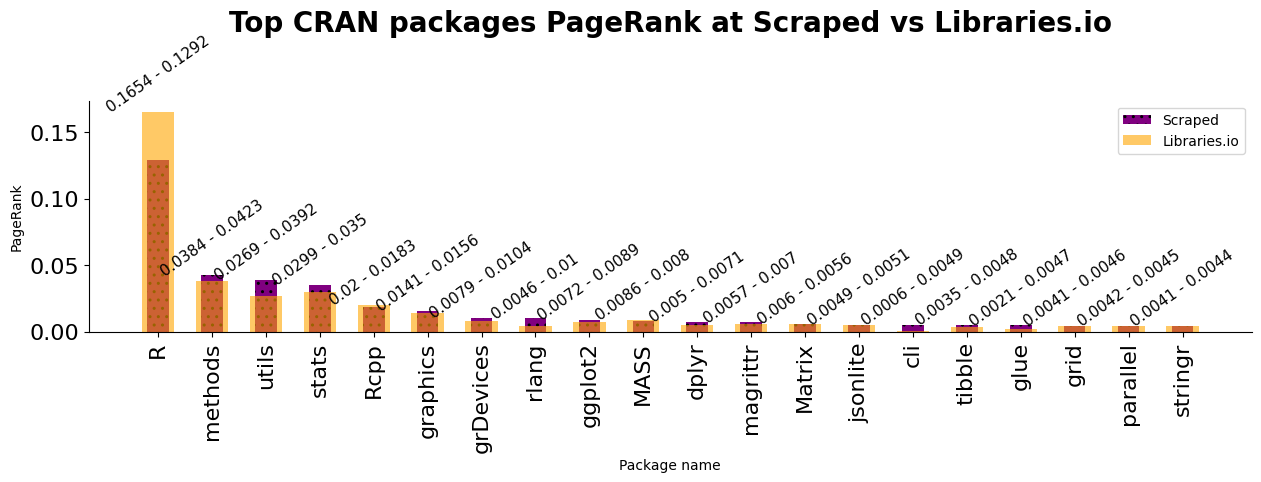

In [29]:
scraped_t20_pr = sorted(nx.pagerank(scraped_G.reverse()).items(), key=lambda x: x[1], reverse=True)[:20]
scraped_t20_pr = [(x[0], round(x[1], 4)) for x in scraped_t20_pr]

plot_dict(
    d = dict(scraped_t20_pr),
    title = 'Top 20 packages PageRank packages at scraped',
    xlabel = 'Package name',
    ylabel = 'PageRank',
    rotation = 40,
    size = (15, 3),
    offset = 0.01,
    label_size = 16,
    font_size = 11,
    label_rotation = 90,
    w=0.6,
    color='purple'
)


# Plot evolution of top PageRank scraped packages
# ---------------------------------------------------

# Get PageRank of each node of top PageRank scraped using the libraries.io graph
pr = nx.pagerank(librariesio_G.reverse())

plot_comparison_reversed(
    ss = scraped_t20_pr,
    tt_G = librariesio_G.reverse(),
    save=True,
    filename=f'{OUT_IMG_DIR}/scraped_t20_pr_comparison.png',
    xticks_rotation=90,
    bar_offset=0.0001,
    xticks_size=16,
    font_size=11,
    rotation=35,
    tittle=f'Top {REPO_NAME} packages PageRank at Scraped vs Libraries.io',
    metric='PageRank',
    comparable={k: round(v, 4) for k, v in pr.items()}
)


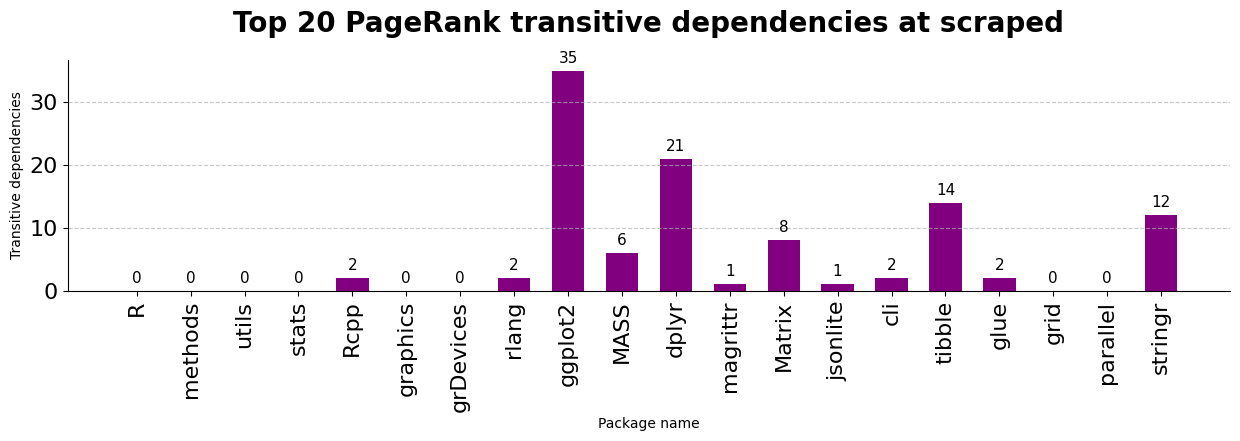

In [30]:
# Top 20 PageRank transitive dependencies at libraries.io
# -------------------------------------------------------


keys = [x[0] for x in scraped_t20_pr]

# get transitive dependencies for each package
transitive_dependencies = {}
for k in keys:

    len_k = len(scraped_model[k].transitive_dependencies())
    transitive_dependencies[k] = len_k


plot_dict(
    d = transitive_dependencies,
    title = 'Top 20 PageRank transitive dependencies at scraped',
    xlabel = 'Package name',
    ylabel = 'Transitive dependencies',
    color='purple',
    rotation = 0,
    offset=2,
    size = (15, 3),
    label_size = 16,
    font_size = 11,
    label_rotation = 90,
    w=0.6
)
    

We can compare other interesting metrics as well.

### **Olivia metrics**

#### **1 - Atack vulnerability**

In [31]:
from olivia.networkmetrics import attack_vulnerability

librariesio_model_attack_vulnerability = attack_vulnerability(librariesio_model, normalize=True)
scraped_model_attack_vulnerability = attack_vulnerability(scraped_model, normalize=True)

print('Attack vulnerability librariesio: {}'.format(librariesio_model_attack_vulnerability))
print('Attack vulnerability scraped: {}'.format(scraped_model_attack_vulnerability))
print('Increase in attack vulnerability: {}'.format(scraped_model_attack_vulnerability - librariesio_model_attack_vulnerability))

Computing Reach


     Processing node: 15K      
Computing Reach
     Processing node: 18K      
Attack vulnerability librariesio: 0.9199846615964722
Attack vulnerability scraped: 0.9224465749022548
Increase in attack vulnerability: 0.0024619133057826037


#### **2 - Failure vulnerability**

In [32]:
from olivia.networkmetrics import failure_vulnerability

librariesio_model_failure_vulnerability = failure_vulnerability(librariesio_model, normalize=True)
scraped_model_failure_vulnerability = failure_vulnerability(scraped_model, normalize=True)

print('Failure vulnerability librariesio: {}'.format(librariesio_model_failure_vulnerability))
print('Failure vulnerability scraped: {}'.format(scraped_model_failure_vulnerability))
print('Increase in failure vulnerability: {}'.format(scraped_model_failure_vulnerability - librariesio_model_failure_vulnerability))

Reach retrieved from metrics cache
Reach retrieved from metrics cache
Failure vulnerability librariesio: 0.0015716137161078264
Failure vulnerability scraped: 0.0017965828672585353
Increase in failure vulnerability: 0.0002249691511507089


#### **3 - Reach**

In [33]:
from olivia.packagemetrics import Reach

librariesio_reach = librariesio_model.get_metric(Reach)
scraped_reach = scraped_model.get_metric(Reach)

Reach retrieved from metrics cache
Reach retrieved from metrics cache


**Top reach**

######

In [34]:
# Top 10 Reach
# ------------

top10_reach_librariesio = librariesio_reach.top(10)
top10_reach_scraped = scraped_reach.top(10)

# Top 10 Reach comparison
top10_reach_comparison = pd.DataFrame(
    {
        'librariesio': top10_reach_librariesio,
        'scraped': top10_reach_scraped
    }
)

top10_reach_comparison

librariesio             scraped
0         (R, 14395)          (R, 17223)
1   (methods, 10839)    (methods, 15103)
2     (utils, 10516)      (utils, 15037)
3      (stats, 9850)      (stats, 14360)
4   (graphics, 7938)   (graphics, 12809)
5  (grDevices, 7382)  (grDevices, 12763)
6       (Rcpp, 7380)        (grid, 9241)
7    (lattice, 6296)       (rlang, 8993)
8      (tools, 6127)     (lattice, 8945)
9       (grid, 5971)    (magrittr, 8916)

**Bottomb reach**

######

In [35]:
# Top 10 least Reach
# ------------------

top10_least_reach_librariesio = librariesio_reach.bottom(10)
top10_least_reach_scraped = scraped_reach.bottom(10)

# Top 10 least Reach comparison
top10_least_reach_comparison = pd.DataFrame(
    {
        'librariesio': top10_least_reach_librariesio,
        'scraped': top10_least_reach_scraped
    }
)

top10_least_reach_comparison

librariesio                 scraped
0              (rdbnomics, 1)              (hoopR, 1)
1              (exiftoolr, 1)            (hlidacr, 1)
2             (multicastR, 1)  (googleCloudRunner, 1)
3        (ROI.plugin.neos, 1)         (ganalytics, 1)
4             (randquotes, 1)             (buildr, 1)
5                 (jsr223, 1)    (academictwitteR, 1)
6  (GoogleKnowledgeGraphR, 1)        (Trendtwosub, 1)
7                   (rsoi, 1)        (Revticulate, 1)
8                 (clinPK, 1)     (conformalbayes, 1)
9                  (nmfem, 1)                 (A3, 1)

**Top reach increase, decrease and variation**

######

In [36]:
# Dataframe with the differences between the two models
librariesio_reach_df = pd.DataFrame(librariesio_reach.results_dict, index=['librariesio']).T
scraped_reach_df = pd.DataFrame(scraped_reach.results_dict, index=['scraped']).T

reach_df = pd.concat([librariesio_reach_df, scraped_reach_df], axis=1)
reach_df['increment'] = reach_df['scraped'] - reach_df['librariesio']
reach_df.sort_values(by='increment', ascending=False, inplace=True)
reach_df.head(10)

librariesio  scraped  increment
lifecycle       1276.0   8462.0     7186.0
grDevices       7382.0  12763.0     5381.0
farver            48.0   5020.0     4972.0
graphics        7938.0  12809.0     4871.0
isoband            5.0   4726.0     4721.0
utils          10516.0  15037.0     4521.0
stats           9850.0  14360.0     4510.0
splines         2016.0   6466.0     4450.0
generics         457.0   4895.0     4438.0
methods        10839.0  15103.0     4264.0

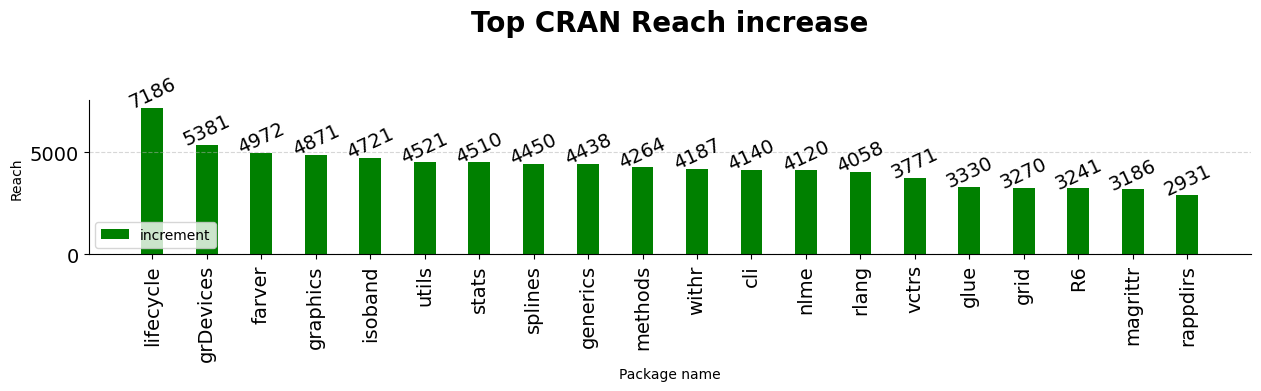

In [37]:
# Top reach increase
# ------------------

increment = reach_df.head(20)

# Plot top reach increase
plt.figure(figsize=(15, 2))

plt.bar(
    increment.index,
    increment['increment'],
    label='increment',
    color='green',
    width=0.4,
)

for i, v in zip(increment.index, increment['increment']):
    plt.text(i, v, f'{int(v)}', color='black', ha='center', rotation=25, fontsize=14)

# Adjusting plot borders
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Adjusting tick labels font size
plt.gca().tick_params(axis='x', labelsize=14, rotation=90)
plt.gca().tick_params(axis='y', labelsize=14)

plt.title(f'Top {REPO_NAME} Reach increase', fontsize=20, fontweight='bold', pad=50)
plt.xlabel('Package name')
plt.ylabel('Reach')
plt.legend(loc='lower left')
# grid
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.savefig(f'{OUT_IMG_DIR}/top_reach_increase.png', bbox_inches='tight')
plt.show()


/tmp/ipykernel_103873/773171109.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  decrement.sort_values(by='increment', ascending=True, inplace=True)


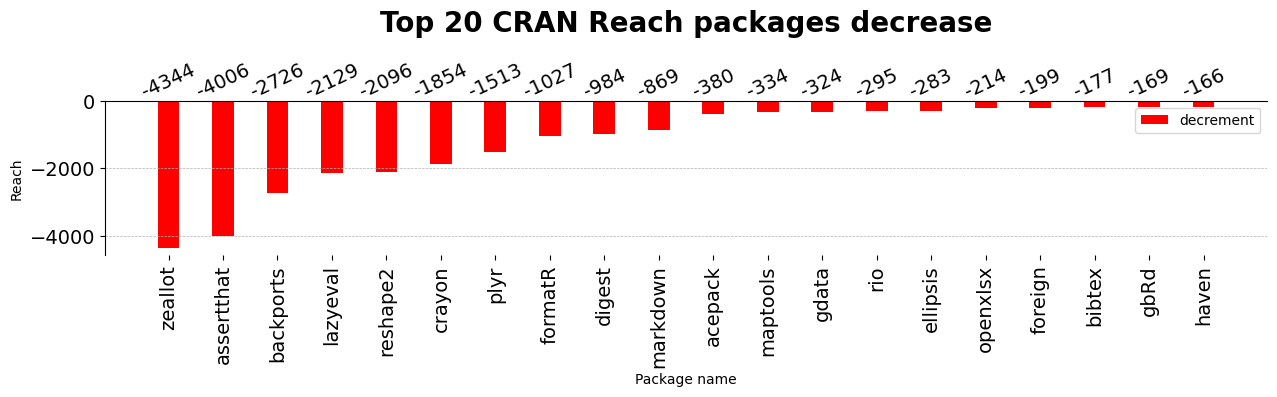

In [38]:
# Decrease in Reach
reach_df = reach_df.dropna()
decrement = reach_df.tail(20)

# sort by increment
decrement.sort_values(by='increment', ascending=True, inplace=True)

# Plot
plt.figure(figsize=(15, 2))

plt.bar(
    decrement.index,
    decrement['increment'],
    label='decrement',
    color='red',
    width=0.4,
)

for i, v in zip(decrement.index, decrement['increment']):
    plt.text(i, 100, f'{int(v)}', color='black', ha='center', rotation=25, fontsize=14)

# Adjusting plot borders
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Adjusting tick labels font size
plt.gca().tick_params(axis='x', labelsize=14, rotation=90)
plt.gca().tick_params(axis='y', labelsize=14)
plt.title(f'Top 20 {REPO_NAME} Reach packages decrease', fontsize=20, fontweight='bold', pad=50)
plt.xlabel('Package name')
plt.ylabel('Reach')
plt.legend()
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.show()


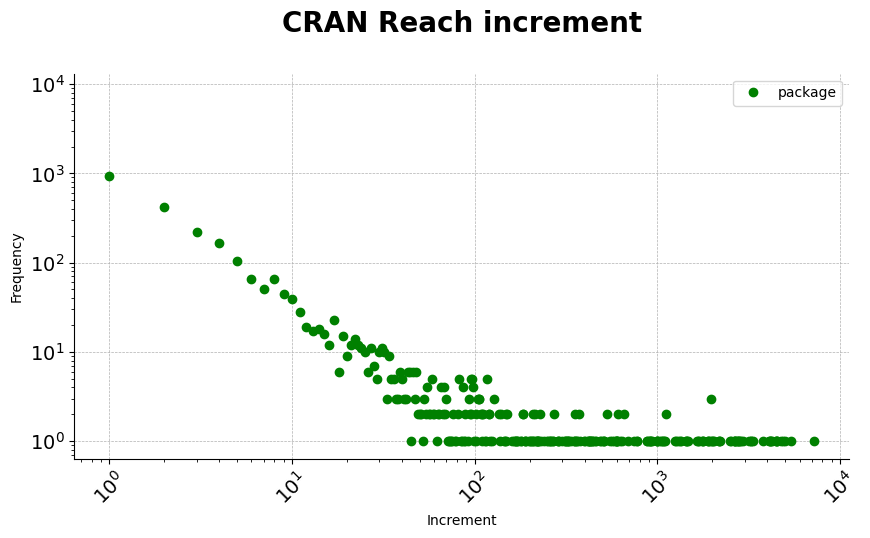

In [112]:
# Reach variation
# ---------------

reach_increment = list(reach_df['increment'].dropna())

# Plot list of reach increase
plt.figure(figsize=(10, 5))

# agrupar em intervalos de 100
reach_increment = [int(x ) for x in reach_increment]
x, y = zip(*Counter(reach_increment).items())

plt.plot(x, y, color='green', marker='o', linestyle='None', label="package")

plt.title(f'{REPO_NAME} Reach increment', fontsize=20, fontweight='bold', pad=30)

# Adjusting plot borders
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Adjusting tick labels font size
plt.gca().tick_params(axis='x', labelsize=14, rotation=45)
plt.gca().tick_params(axis='y', labelsize=14)
plt.xlabel('Increment')
plt.ylabel('Frequency')
plt.legend()
plt.grid(axis='x', linestyle='--', linewidth=0.5)
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.xscale('log')
plt.yscale('log')
plt.show()

**Reach evolution**

######

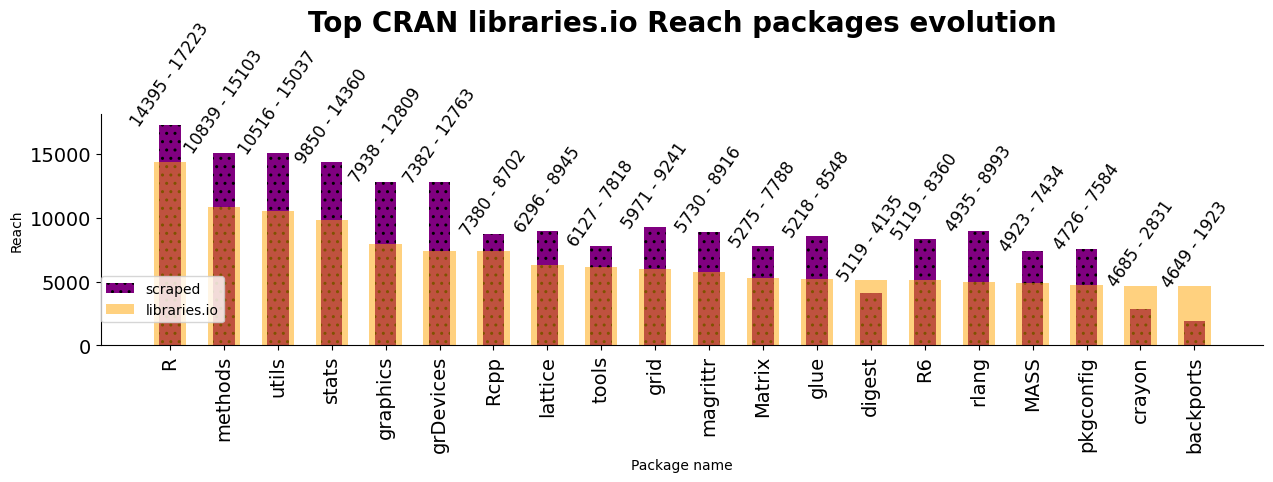

In [110]:

# Top librariesio reach evolution 
# --------------------------------

# Get the top 10 packages with the highest Reach in the libraries.io model
top_reach_librariesio = dict(librariesio_reach.top(20))

# Get the Reach of the packages in the scraped model
top_reach_scraped = {}
reach_scraped = scraped_reach.results_dict
for package in top_reach_librariesio.keys():
    if package in reach_scraped.keys():
        top_reach_scraped[package] = reach_scraped[package]
    else:
        top_reach_scraped[package] = 0


# Plot comparison
plt.figure(figsize=(15, 3))

plt.bar(
    [x[0] for x in top_reach_scraped.items()],
    [x[1] for x in top_reach_scraped.items()],
    label='scraped',
    color='purple',
    width=0.4,
    hatch='..'
)

plt.bar(
    [x[0] for x in top_reach_librariesio.items()],
    [x[1] for x in top_reach_librariesio.items()],
    label='libraries.io',
    color='orange',
    width=0.6,
    alpha=0.5,
)

for i, v, i2, v2 in zip([x[0] for x in top_reach_librariesio.items()], [x[1] for x in top_reach_librariesio.items()], [x[0] for x in top_reach_scraped.items()], [x[1] for x in top_reach_scraped.items()]):
    plt.text(i, max(v,v2)+0.0005, f'{v} - {v2}', color='black', ha='center', rotation=55, fontsize=12)

# Adjusting plot borders
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Adjusting tick labels font size
plt.gca().tick_params(axis='x', labelsize=14, rotation=90)
plt.gca().tick_params(axis='y', labelsize=14)
plt.title(f'Top {REPO_NAME} libraries.io Reach packages evolution', fontsize=20, fontweight='bold', pad=60)
plt.xlabel('Package name')
plt.ylabel('Reach')
plt.legend(loc=(0, 0.1))

plt.savefig(f'{OUT_IMG_DIR}/top_librariesio_reach_evolution.png', bbox_inches='tight')
plt.show()

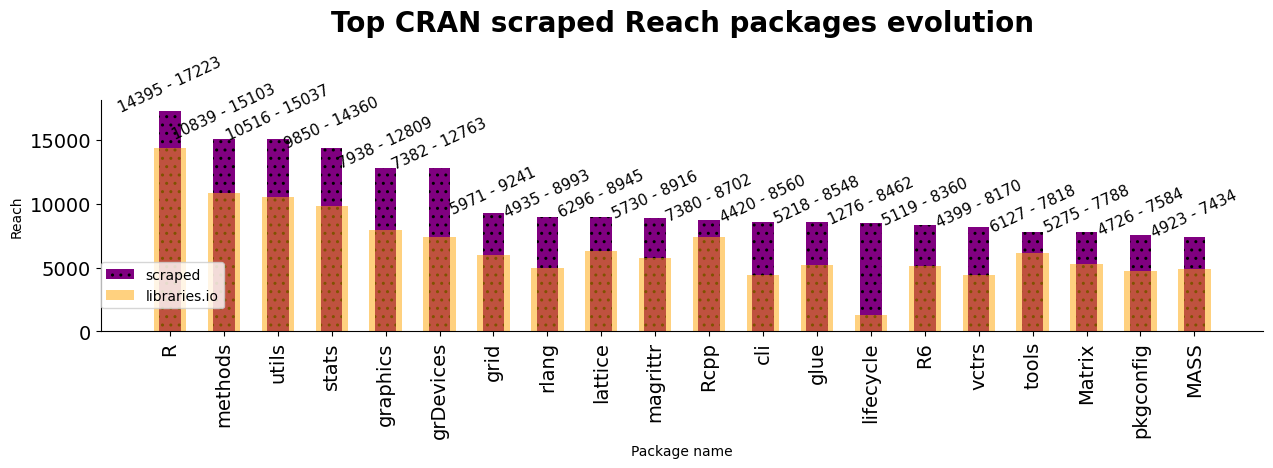

In [113]:
# Top scraped reach evolution
# ----------------------------

# Get the top 10 packages with the highest Reach in the scraped model
top_reach_scraped = dict(scraped_reach.top(20))

# Get the Reach of the packages in the libraries.io model
top_reach_librariesio = {}
reach_librariesio = librariesio_reach.results_dict
for package in top_reach_scraped.keys():
    if package in reach_librariesio.keys():
        top_reach_librariesio[package] = reach_librariesio[package]
    else:
        top_reach_librariesio[package] = 0


# Plot comparison
plt.figure(figsize=(15, 3))
plt.bar(
    [x[0] for x in top_reach_scraped.items()],
    [x[1] for x in top_reach_scraped.items()],
    label='scraped',
    color='purple',
    width=0.4,
    hatch='..'
)
plt.bar(
    [x[0] for x in top_reach_librariesio.items()],
    [x[1] for x in top_reach_librariesio.items()],
    label='libraries.io',
    color='orange',
    width=0.6,
    alpha=0.5,
)

for i, v, i2, v2 in zip([x[0] for x in top_reach_librariesio.items()], [x[1] for x in top_reach_librariesio.items()], [x[0] for x in top_reach_scraped.items()], [x[1] for x in top_reach_scraped.items()]):
    plt.text(i, max(v,v2)+0.0005, f'{v} - {v2}', color='black', ha='center', rotation=25, fontsize=11)

# Adjusting plot borders
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Adjusting tick labels font size
plt.gca().tick_params(axis='x', labelsize=14, rotation=90)
plt.gca().tick_params(axis='y', labelsize=14)
plt.title(f'Top {REPO_NAME} scraped Reach packages evolution', fontsize=20, fontweight='bold', pad=50)
plt.xlabel('Package name')
plt.ylabel('Reach')
plt.legend(loc=(0, 0.1))

plt.savefig(f'{OUT_IMG_DIR}/top_scraped_reach_evolution.png', bbox_inches='tight')
plt.show()


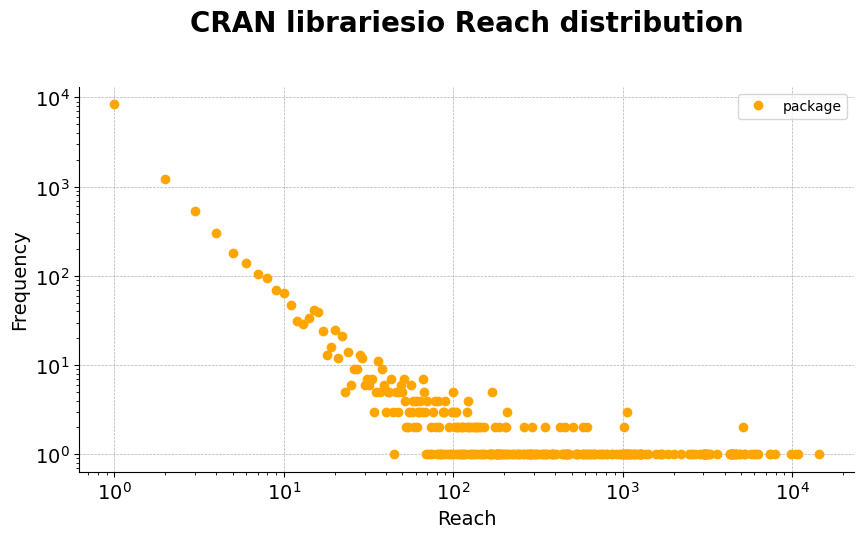

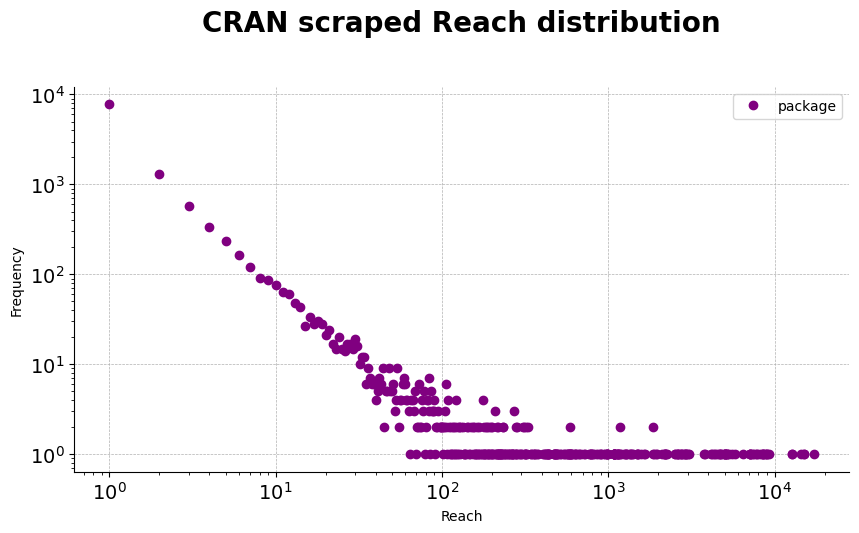

In [42]:
# Reach distribution for libraries.io
# -----------------------------------

# Plot distribution
plt.figure(figsize=(10, 5))
reach = list(reach_df['librariesio'].dropna())
x, y = zip(*Counter(reach).items())

plt.plot(x, y, color='orange', marker='o', linestyle='None', label="package")

plt.title(f'{REPO_NAME} librariesio Reach distribution', fontsize=20, fontweight='bold', pad=40)

# Adjusting plot borders
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Adjusting tick labels font size
plt.gca().tick_params(axis='x', labelsize=14)
plt.gca().tick_params(axis='y', labelsize=14)
plt.xlabel('Reach', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.legend()
plt.grid(axis='x', linestyle='--', linewidth=0.5)
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.xscale('log')
plt.yscale('log')

plt.savefig(f'{OUT_IMG_DIR}/librariesio_reach_distribution.png', bbox_inches='tight')
plt.show()


# Reach distribution for scraped
# -----------------------------

# Plot distribution
plt.figure(figsize=(10, 5))
reach = list(reach_df['scraped'].dropna())
x, y = zip(*Counter(reach).items())

plt.plot(x, y, color='purple', marker='o', linestyle='None', label="package")

plt.title(f'{REPO_NAME} scraped Reach distribution', fontsize=20, fontweight='bold', pad=40)

# Adjusting plot borders
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Adjusting tick labels font size
plt.gca().tick_params(axis='x', labelsize=14)
plt.gca().tick_params(axis='y', labelsize=14)
plt.xlabel('Reach')
plt.ylabel('Frequency')
plt.legend()
plt.grid(axis='x', linestyle='--', linewidth=0.5)
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.xscale('log')
plt.yscale('log')

plt.savefig(f'{OUT_IMG_DIR}/scraped_reach_distribution.png', bbox_inches='tight')
plt.show()



#### **4 - Impact**

In [43]:
from olivia.packagemetrics import Impact

librariesio_impact = librariesio_model.get_metric(Impact)
scraped_impact = scraped_model.get_metric(Impact)

Computing Impact
     Processing node: 15K      
Computing Impact
     Processing node: 18K      


**Top impact**

######

In [44]:
# Top 10 impact
# -------------

top10_impact_librariesio = librariesio_impact.top(10)
top10_impact_scraped = scraped_impact.top(10)

# Top 10 impact comparison
top10_impact_comparison = pd.DataFrame(
    {
        'librariesio': top10_impact_librariesio,
        'scraped': top10_impact_scraped
    }
)

top10_impact_comparison

librariesio             scraped
0          (R, 56281)          (R, 84501)
1    (methods, 35926)      (utils, 63116)
2      (utils, 34259)    (methods, 61571)
3      (stats, 27322)      (stats, 52319)
4  (grDevices, 19445)  (grDevices, 43340)
5   (graphics, 19117)   (graphics, 41571)
6       (Rcpp, 17781)      (rlang, 30475)
7      (tools, 15897)   (magrittr, 28508)
8   (magrittr, 14676)        (cli, 27514)
9    (lattice, 13168)       (glue, 27453)

**Bottom impact**

######

In [45]:
# Top 10 less impact
# ------------------

top10_less_impact_librariesio = librariesio_impact.bottom(10)
top10_less_impact_scraped = scraped_impact.bottom(10)

# Top 10 less impact comparison
top10_less_impact_comparison = pd.DataFrame(
    {
        'librariesio': top10_less_impact_librariesio,
        'scraped': top10_less_impact_scraped
    }
)

top10_less_impact_comparison

librariesio                 scraped
0              (rdbnomics, 0)              (hoopR, 0)
1              (exiftoolr, 0)            (hlidacr, 0)
2             (multicastR, 0)  (googleCloudRunner, 0)
3        (ROI.plugin.neos, 0)         (ganalytics, 0)
4             (randquotes, 0)             (buildr, 0)
5                 (jsr223, 0)    (academictwitteR, 0)
6  (GoogleKnowledgeGraphR, 0)        (Trendtwosub, 0)
7                   (rsoi, 0)        (Revticulate, 0)
8                 (clinPK, 0)     (conformalbayes, 0)
9                  (nmfem, 0)                 (A3, 0)

**Top impact increase, decrease y variation**

######

In [104]:
# Dataframe with the increments between the two models
librariesio_impact_df = pd.DataFrame(librariesio_impact.results_dict, index=['librariesio']).T
scraped_impact_df = pd.DataFrame(scraped_impact.results_dict, index=['scraped']).T

impact_df = pd.concat([librariesio_impact_df, scraped_impact_df], axis=1)
impact_df['increment'] = impact_df['scraped'] - impact_df['librariesio']
impact_df.sort_values(by='increment', ascending=False, inplace=True)
impact_df.head(10)

librariesio  scraped  increment
utils          34259.0  63116.0    28857.0
R              56281.0  84501.0    28220.0
methods        35926.0  61571.0    25645.0
lifecycle       1656.0  26783.0    25127.0
stats          27322.0  52319.0    24997.0
grDevices      19445.0  43340.0    23895.0
graphics       19117.0  41571.0    22454.0
cli             9144.0  27514.0    18370.0
rlang          12362.0  30475.0    18113.0
vctrs           9056.0  24235.0    15179.0

<Figure size 1500x300 with 0 Axes>

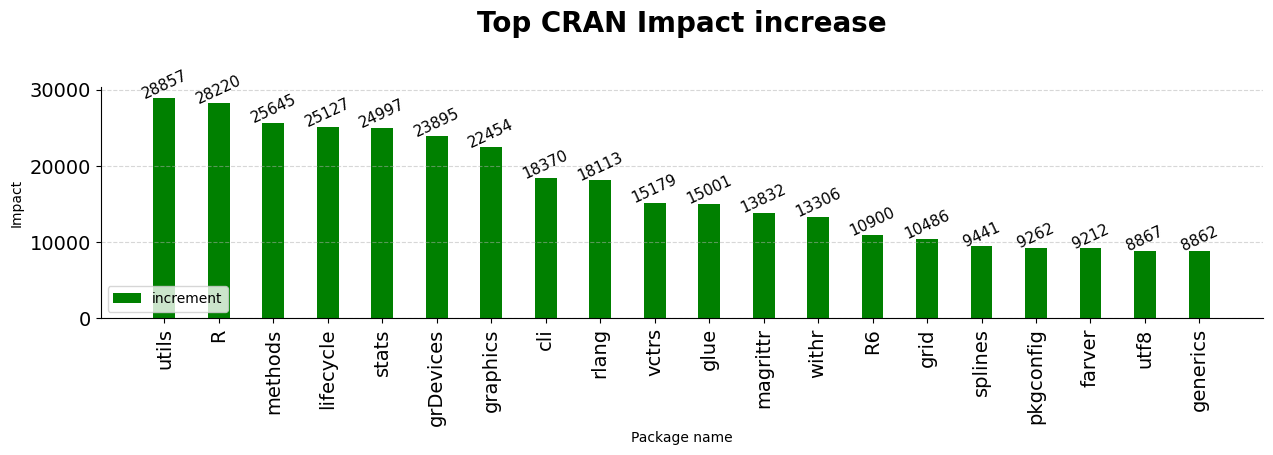

In [47]:
# Plot increment
plt.figure(figsize=(15, 3))
increment = impact_df.head(20)

# Plot top reach increase
plt.figure(figsize=(15, 3))

plt.bar(
    increment.index,
    increment['increment'],
    label='increment',
    color='green',
    width=0.4,
)

for i, v in zip(increment.index, increment['increment']):
    plt.text(i, v, f'{int(v)}', color='black', ha='center', rotation=25, fontsize=11)

# Adjusting plot borders
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Adjusting tick labels font size
plt.gca().tick_params(axis='x', labelsize=14, rotation=90)
plt.gca().tick_params(axis='y', labelsize=14)

plt.title(f'Top {REPO_NAME} Impact increase', fontsize=20, fontweight='bold', pad=40)
plt.xlabel('Package name')
plt.ylabel('Impact')
plt.legend(loc='lower left')
# grid
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()


**Top impact decrease**

######

In [105]:
# Decrease in impact
impact_df = impact_df.dropna()
impact_df.tail(10)

librariesio  scraped  increment
markdown         1511.0    324.0    -1187.0
formatR          1450.0     90.0    -1360.0
lazyeval         4662.0   1193.0    -3469.0
plyr             6265.0   2710.0    -3555.0
digest          11895.0   8100.0    -3795.0
reshape2         5217.0   1232.0    -3985.0
crayon          10407.0   4645.0    -5762.0
backports        9876.0   2785.0    -7091.0
assertthat       9667.0    704.0    -8963.0
zeallot          9070.0     67.0    -9003.0

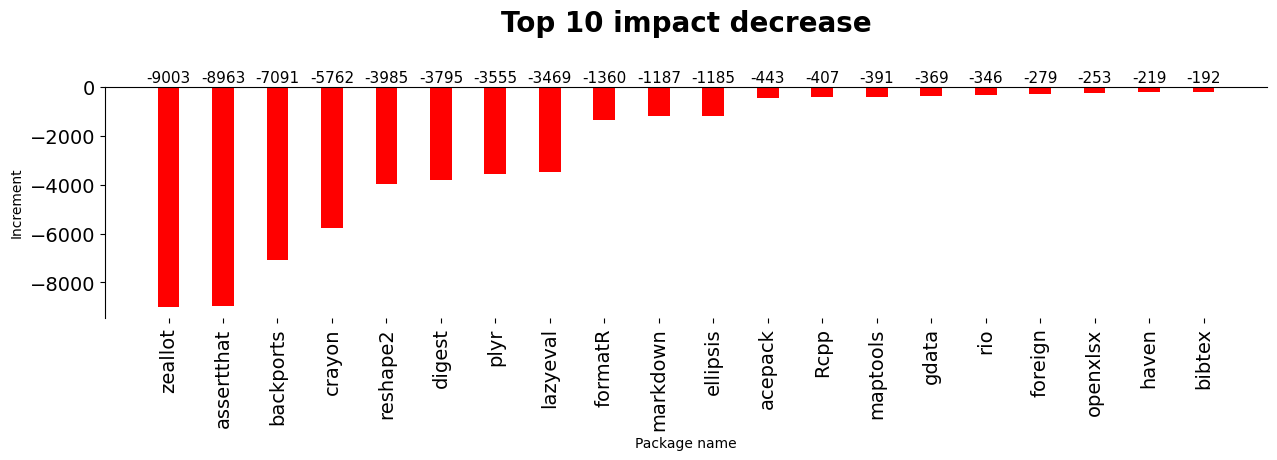

In [49]:
# Plot decrease
plt.figure(figsize=(15, 3))
decrease = impact_df.tail(20).astype(int)

# sort by increment
decrease.sort_values(by='increment', ascending=True, inplace=True)

plt.bar(
    decrease.index,
    decrease['increment'],
    color='red',
    width=0.4,
)

for i, v in zip(decrease.index, decrease['increment']):
    plt.text(i, 200, f'{v}', color='black', ha='center', rotation=0, fontsize=11)

# Adjusting plot borders
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Adjusting tick labels font size
plt.gca().tick_params(axis='x', labelsize=14, rotation=90)
plt.gca().tick_params(axis='y', labelsize=14)

plt.title('Top 10 impact decrease', fontsize=20, fontweight='bold', pad=40)
plt.xlabel('Package name')
plt.ylabel('Increment')

plt.savefig(f'{OUT_IMG_DIR}/impact_decrease.png', bbox_inches='tight')
plt.show()


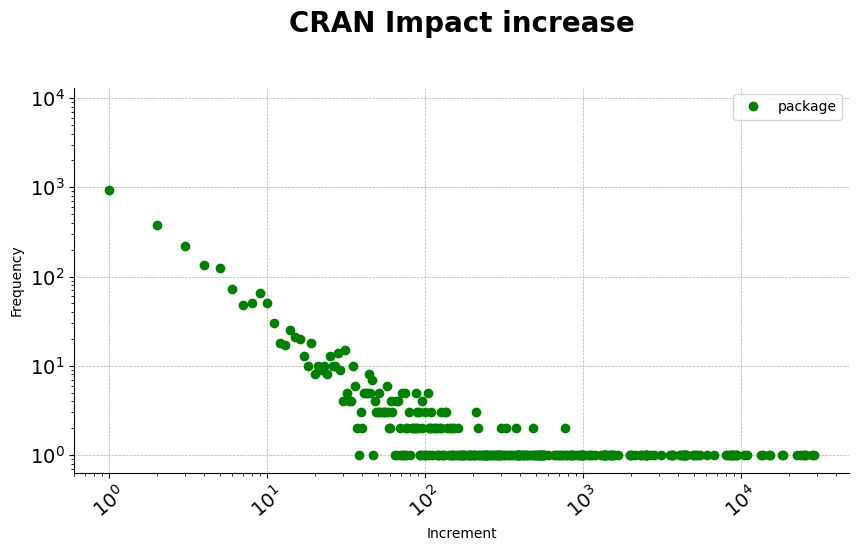

In [94]:
# Reach variation
# ---------------

impact_increase = list(impact_df['increment'].dropna())
impact_increase.sort(reverse=True)

# Plot impact increase
plt.figure(figsize=(10, 5))

# agrupar em intervalos de 100
impact_increase = [int(x / 1)  for x in impact_increase]
x, y = zip(*Counter(impact_increase).items())

plt.plot(x, y, color='green', marker='o', linestyle='None', label='package')

plt.title(f'{REPO_NAME} Impact increase', fontsize=20, fontweight='bold', pad=40)

# Adjusting plot borders

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Adjusting tick labels font size
plt.gca().tick_params(axis='x', labelsize=14, rotation=40)
plt.gca().tick_params(axis='y', labelsize=14)
plt.ylabel('Frequency')
plt.xlabel('Increment')
plt.legend()
plt.grid(axis='x', linestyle='--', linewidth=0.5)
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.xscale('log')
plt.yscale('log')
plt.show()

**Evolution**

######

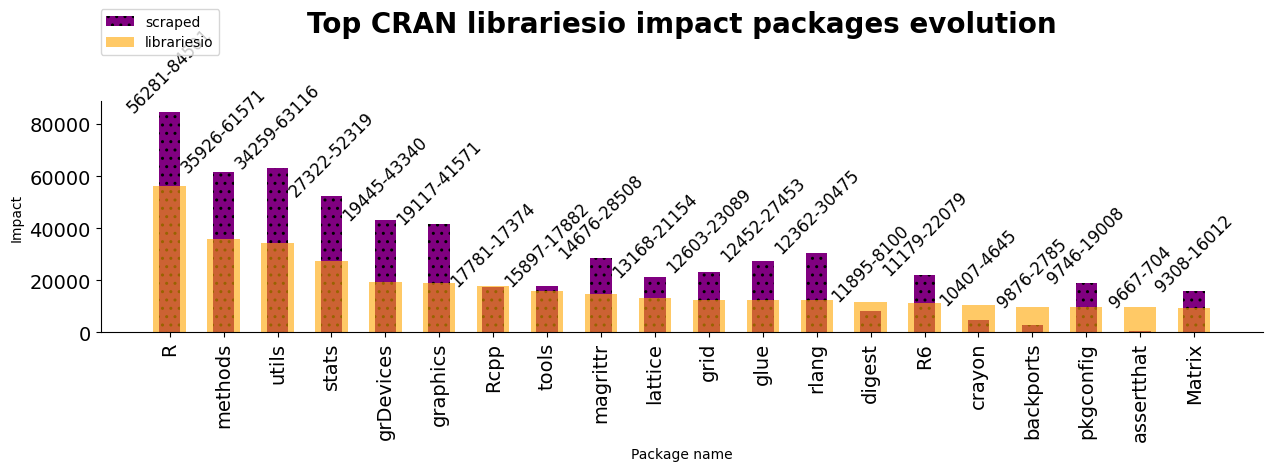

In [97]:
# Top librariesio impact packages evolution
# -----------------------------------------

top_impact_librariesio = dict(librariesio_impact.top(20))

# Get the impact of the top librariesio packages in the scraped model
top_impact_scraped = {}
for package in top_impact_librariesio.keys():
    try:
        top_impact_scraped[package] = scraped_impact.results_dict[package]
    except KeyError:
        top_impact_scraped[package] = 0

# Plot top impact packages evolution
plt.figure(figsize=(15, 3))



plt.bar(
    [x[0] for x in top_impact_scraped.items()],
    [x[1] for x in top_impact_scraped.items()],
    label='scraped',
    color='purple',
    width=0.4,
    hatch='..'
)

plt.bar(
    [x[0] for x in top_impact_librariesio.items()],
    [x[1] for x in top_impact_librariesio.items()],
    label='librariesio',
    color='orange',
    width=0.6,
    alpha=0.6,
)

for i, v, v2 in zip([x[0] for x in top_impact_librariesio.items()], [x[1] for x in top_impact_librariesio.items()], [x[1] for x in top_impact_scraped.items()]):
    plt.text(i, max(v,v2), f'{int(v)}-{int(v2)}', color='black', ha='center', rotation=45, fontsize=12)

# Adjusting plot borders
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Adjusting tick labels font size
plt.gca().tick_params(axis='x', labelsize=14, rotation=90)
plt.gca().tick_params(axis='y', labelsize=14)

plt.title(f'Top {REPO_NAME} librariesio impact packages evolution', fontsize=20, fontweight='bold', pad=50)

plt.xlabel('Package name')
plt.ylabel('Impact')
plt.legend(loc=(0,1.2))

# save plot
plt.savefig(f'{OUT_IMG_DIR}/top_librariesio_impact_packages_evolution.png', bbox_inches='tight')
plt.show()

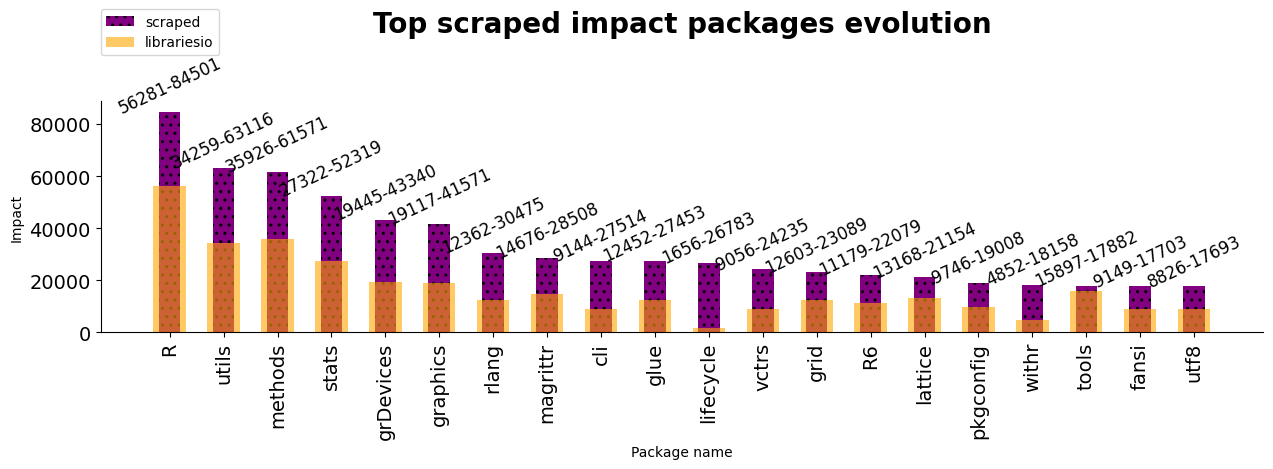

In [98]:
# Top scraped impact packages evolution
# -------------------------------------

# order impact by librariesio value
impact_df.sort_values(by='scraped', ascending=False, inplace=True)
top_impact_scraped = dict(impact_df.head(20)['scraped'])

# Get the impact of the top scraped packages in the librariesio model
top_impact_librariesio = {}
for package in top_impact_scraped.keys():
    try:
        top_impact_librariesio[package] = librariesio_impact.results_dict[package]
    except KeyError:
        top_impact_librariesio[package] = 0

# Plot top impact packages evolution
plt.figure(figsize=(15, 3))
plt.bar(
    [x[0] for x in top_impact_scraped.items()],
    [x[1] for x in top_impact_scraped.items()],
    label='scraped',
    color='purple',
    width=0.4,
    hatch='..'
)

plt.bar(
    [x[0] for x in top_impact_librariesio.items()],
    [x[1] for x in top_impact_librariesio.items()],
    label='librariesio',
    color='orange',
    width=0.6,
    alpha=0.6,
)

for i, v, v2 in zip([x[0] for x in top_impact_librariesio.items()], [x[1] for x in top_impact_librariesio.items()], [x[1] for x in top_impact_scraped.items()]):
    plt.text(i, max(v,v2), f'{int(v)}-{int(v2)}', color='black', ha='center', rotation=25, fontsize=12)

# Adjusting plot borders
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Adjusting tick labels font size
plt.gca().tick_params(axis='x', labelsize=14, rotation=90)
plt.gca().tick_params(axis='y', labelsize=14)

plt.title('Top scraped impact packages evolution', fontsize=20, fontweight='bold', pad=50)

plt.xlabel('Package name')
plt.ylabel('Impact')
plt.legend(loc=(0,1.2))

# save plot
plt.savefig(f'{OUT_IMG_DIR}/top_scraped_impact_packages_evolution.png', bbox_inches='tight')
plt.show()

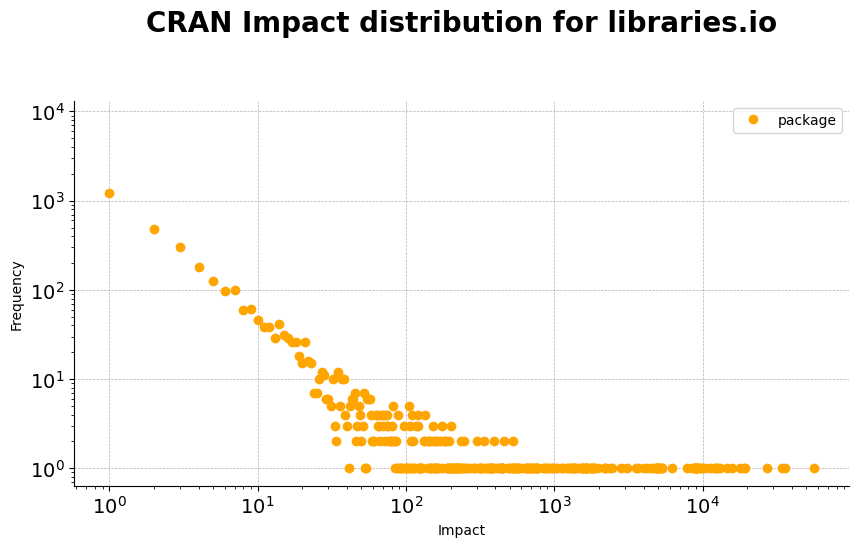

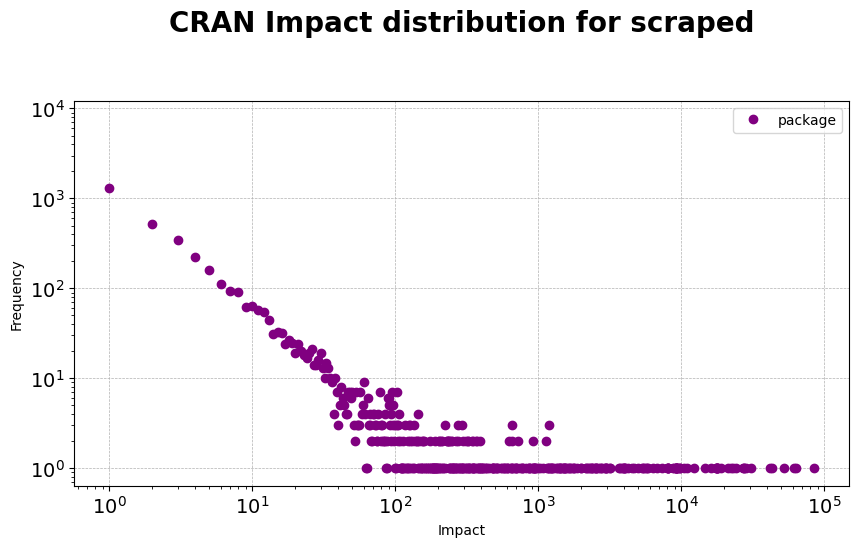

In [53]:
# Impact distribution for libraries.io
# ------------------------------------

# Plot impact distribution
plt.figure(figsize=(10, 5))

impact = list(impact_df['librariesio'].dropna())
x, y = zip(*Counter(impact).items())

plt.plot(x, y, color='orange', marker='o', linestyle='None', label='package')

plt.title(f'{REPO_NAME} Impact distribution for libraries.io', fontsize=20, fontweight='bold', pad=50)

# Adjusting plot borders
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Adjusting tick labels font size
plt.gca().tick_params(axis='x', labelsize=14, rotation=0)
plt.gca().tick_params(axis='y', labelsize=14)
plt.xlabel('Impact')
plt.ylabel('Frequency')
plt.legend()
plt.grid(axis='x', linestyle='--', linewidth=0.5)
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.xscale('log')
plt.yscale('log')




# save plot
plt.savefig(f'{OUT_IMG_DIR}/librariesio_impact_distribution.png', bbox_inches='tight')
plt.show()

# Impact distribution for scraped
# -------------------------------

# Plot impact distribution
plt.figure(figsize=(10, 5))

impact = list(impact_df['scraped'].dropna())
x, y = zip(*Counter(impact).items())

plt.plot(x, y, color='purple', marker='o', linestyle='None', label='package')
plt.title(f'{REPO_NAME} Impact distribution for scraped', fontsize=20, fontweight='bold', pad=50)

# Adjusting tick labels font size
plt.gca().tick_params(axis='x', labelsize=14, rotation=0)
plt.gca().tick_params(axis='y', labelsize=14)
plt.xlabel('Impact')
plt.ylabel('Frequency')
plt.legend()
plt.grid(axis='x', linestyle='--', linewidth=0.5)
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.xscale('log')
plt.yscale('log')

#Calcular el valor medio de la distribución

# save plot
plt.savefig(f'{OUT_IMG_DIR}/scraped_impact_distribution.png', bbox_inches='tight')
plt.show()






#### **5 - Surface**

In [54]:
from olivia.packagemetrics import Surface

librariesio_surface = librariesio_model.get_metric(Surface)
scraped_surface = scraped_model.get_metric(Surface)

Computing Surface


     Processing node: 0K       
Computing Surface
     Processing node: 0K       


**Top surface**

######

In [55]:
# Top 10 surface comparison
# -------------------------

top10_librariesio_surface = librariesio_surface.top(10)
top10_scraped_surface = scraped_surface.top(10)

# Top 10 surface comparison
top10_surface_df = pd.DataFrame(
    {
        'librariesio': top10_librariesio_surface,
        'scraped': top10_scraped_surface,
    }
)
top10_surface_df

librariesio                scraped
0    (smartdata, 246)          (sMSROC, 253)
1  (ggstatsplot, 220)        (popstudy, 237)
2         (STAT, 195)    (PsychWordVec, 235)
3     (psychNET, 191)           (PALMO, 225)
4     (KNNShiny, 189)         (wallace, 224)
5       (KarsTS, 188)        (jsmodule, 224)
6     (biospear, 180)           (RISCA, 223)
7       (mdsOpt, 178)  (TidyConsultant, 221)
8   (statVisual, 173)           (mlmts, 218)
9    (PREPShiny, 171)      (packDAMipd, 215)

**Bottom surface**

###### 

In [56]:
# Top 10 less surface
# ----------------

top10_librariesio_surface = librariesio_surface.bottom(10)
top10_scraped_surface = scraped_surface.bottom(10)

# Top 10 surface comparison
top10_surface_df = pd.DataFrame(
    {
        'librariesio': top10_librariesio_surface,
        'scraped': top10_scraped_surface,
    }
)
top10_surface_df

librariesio           scraped
0           (syskern, 1)       (hellno, 1)
1           (fANCOVA, 1)     (graphics, 1)
2            (GIGrvg, 1)      (geodist, 1)
3  (RDAVIDWebService, 1)     (snpStats, 1)
4          (KEGGREST, 1)    (proftools, 1)
5    (preprocessCore, 1)    (Nozzle.R1, 1)
6         (LowRankQP, 1)         (emoa, 1)
7          (labeling, 1)        (GO.db, 1)
8          (sampling, 1)  (SeqVarTools, 1)
9           (intrval, 1)     (procmaps, 1)

**Top surface increment**

######

In [57]:
# Dataframe with the increments between the two models
librariesio_surface_df = pd.DataFrame(librariesio_surface.results_dict, index=['librariesio']).T
scraped_surface_df = pd.DataFrame(scraped_surface.results_dict, index=['scraped']).T

surface_df = pd.concat([librariesio_surface_df, scraped_surface_df], axis=1)
surface_df['increment'] = surface_df['scraped'] - surface_df['librariesio']
surface_df.sort_values(by='increment', ascending=False, inplace=True)
surface_df.head(10)


librariesio  scraped  increment
RcmdrPlugin.EBM           2.0    172.0      170.0
MonoPhy                  12.0    152.0      140.0
RcmdrPlugin.coin          2.0    141.0      139.0
BrailleR                  2.0    140.0      138.0
tswge                    13.0    151.0      138.0
RcmdrPlugin.ROC           2.0    136.0      134.0
QFASA                    25.0    156.0      131.0
ENMeval                  21.0    143.0      122.0
RISCA                   102.0    223.0      121.0
funtimes                 20.0    141.0      121.0

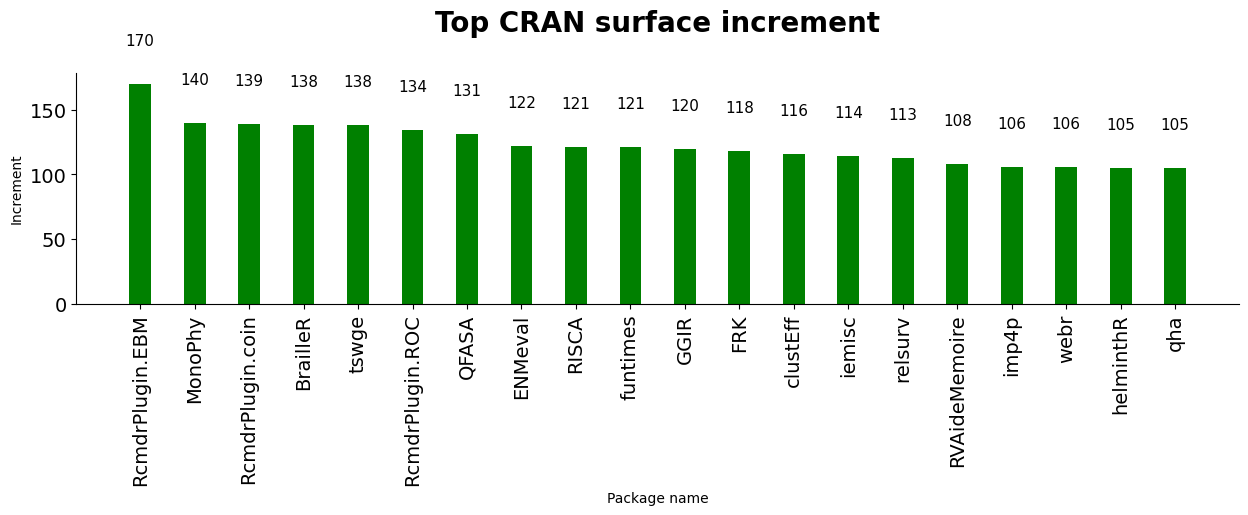

In [58]:
# Plot surface increment
plt.figure(figsize=(15, 3))

increment = surface_df.head(20).astype(int)

plt.bar(
    increment.index,
    increment['increment'],
    color='green',
    width=0.4,
)

for i, v in zip(increment.index, increment['increment']):
    plt.text(i, v+30, f'{v}', color='black', ha='center', rotation=0, fontsize=11)

# Adjusting plot borders
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Adjusting tick labels font size
plt.gca().tick_params(axis='x', labelsize=14, rotation=90)
plt.gca().tick_params(axis='y', labelsize=14)
plt.title(f'Top {REPO_NAME} surface increment', fontsize=20, fontweight='bold', pad=30)

plt.xlabel('Package name')
plt.ylabel('Increment')

plt.savefig(f'{OUT_IMG_DIR}/top_surface_increment.png', bbox_inches='tight')
plt.show()


**Top surface decrease**

######

In [59]:
# Decrease in surface
# -------------------

# Remove the rows with NaN values
surface_df = surface_df.dropna()
surface_df.tail(10)

librariesio  scraped  increment
MMLR                98.0      7.0      -91.0
MSEtool            139.0     47.0      -92.0
WindCurves         105.0      9.0      -96.0
JFE                153.0     55.0      -98.0
RRphylo            147.0     43.0     -104.0
momentuHMM         163.0     59.0     -104.0
mvoutlier          116.0     10.0     -106.0
psycho             167.0     49.0     -118.0
maGUI              130.0      5.0     -125.0
ggstatsplot        220.0     77.0     -143.0

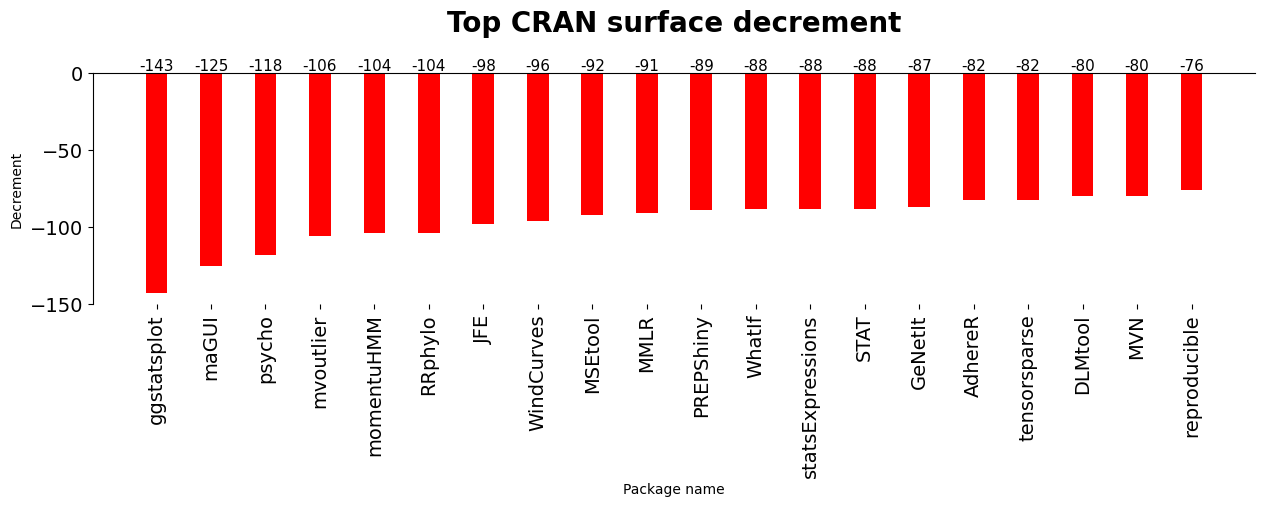

In [60]:
# Plot surface decrement
plt.figure(figsize=(15, 3))

decrement = surface_df.tail(20).astype(int)

decrement.sort_values(by='increment', ascending=True, inplace=True)

plt.bar(
    decrement.index,
    decrement['increment'],
    color='red',
    width=0.4,
)

for i, v in zip(decrement.index, decrement['increment']):
    plt.text(i, 2, f'{v}', color='black', ha='center', rotation=0, fontsize=11)

# Adjusting plot borders
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Adjusting tick labels font size
plt.gca().tick_params(axis='x', labelsize=14, rotation=90)
plt.gca().tick_params(axis='y', labelsize=14)
plt.title(f'Top {REPO_NAME} surface decrement', fontsize=20, fontweight='bold', pad=30)

plt.xlabel('Package name')

plt.ylabel('Decrement')
plt.show()


**Evolution**

######

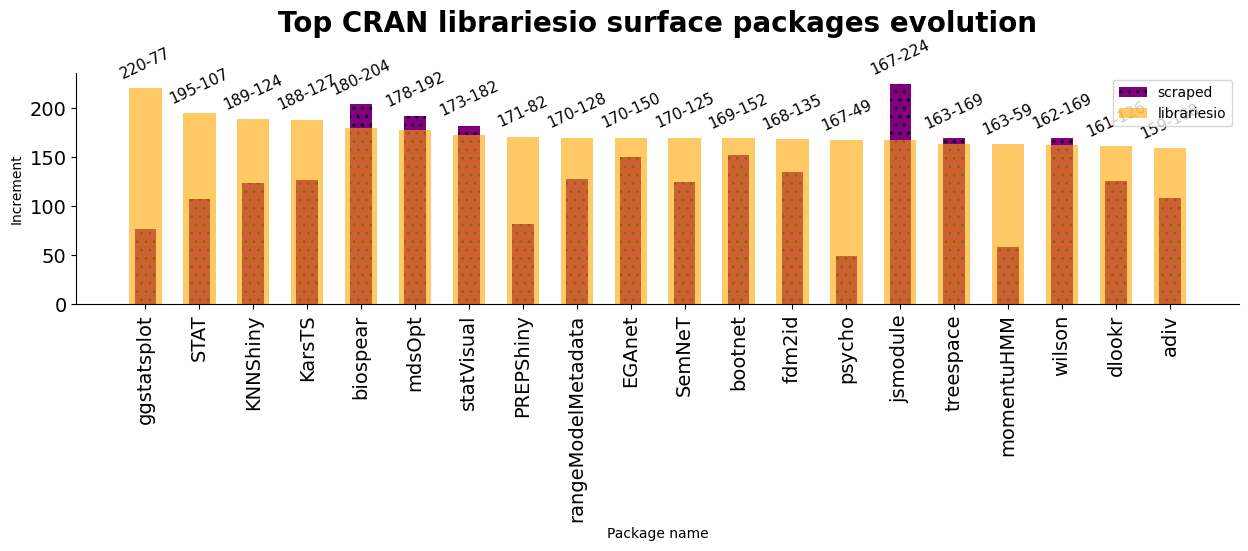

In [61]:
# Evolution of the top librariesio surface packages
# ------------------------------------------------

# order surface by librariesio value
surface_df.sort_values(by='librariesio', ascending=False, inplace=True)
top_surface_librariesio = dict(surface_df.head(20)['librariesio'])

# Get the surface of the top librariesio packages for scraped model
top_surface_scraped = {}
for package in top_surface_librariesio.keys():
    try:
        top_surface_scraped[package] = scraped_surface.results_dict[package]
    except KeyError:
        print(f'Package {package} not found in scraped model')
        top_surface_scraped[package] = 0

# Plot the evolution of the top librariesio surface packages
plt.figure(figsize=(15, 3))

plt.bar(
    [x[0] for x in top_surface_scraped.items()],
    [x[1] for x in top_surface_scraped.items()],
    label='scraped',
    color='purple',
    width=0.4,
    hatch='..'
)

plt.bar(
    [x[0] for x in top_surface_librariesio.items()],
    [x[1] for x in top_surface_librariesio.items()],

    label='librariesio',
    color='orange',
    width=0.6,
    alpha=0.6,
)

for i, v, v2 in zip([x[0] for x in top_surface_librariesio.items()], [x[1] for x in top_surface_librariesio.items()], [x[1] for x in top_surface_scraped.items()]):
    plt.text(i, max(v,v2)+10, f'{int(v)}-{v2}', color='black', ha='center', rotation=25, fontsize=11)

# Adjusting plot borders
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Adjusting tick labels font size
plt.gca().tick_params(axis='x', labelsize=14, rotation=90)
plt.gca().tick_params(axis='y', labelsize=14)

plt.title(f'Top {REPO_NAME} librariesio surface packages evolution', fontsize=20, fontweight='bold', pad=30)

plt.xlabel('Package name')
plt.ylabel('Increment')
plt.legend()

plt.savefig(f'{OUT_IMG_DIR}/top_surface_evolution.png', bbox_inches='tight')
plt.show()


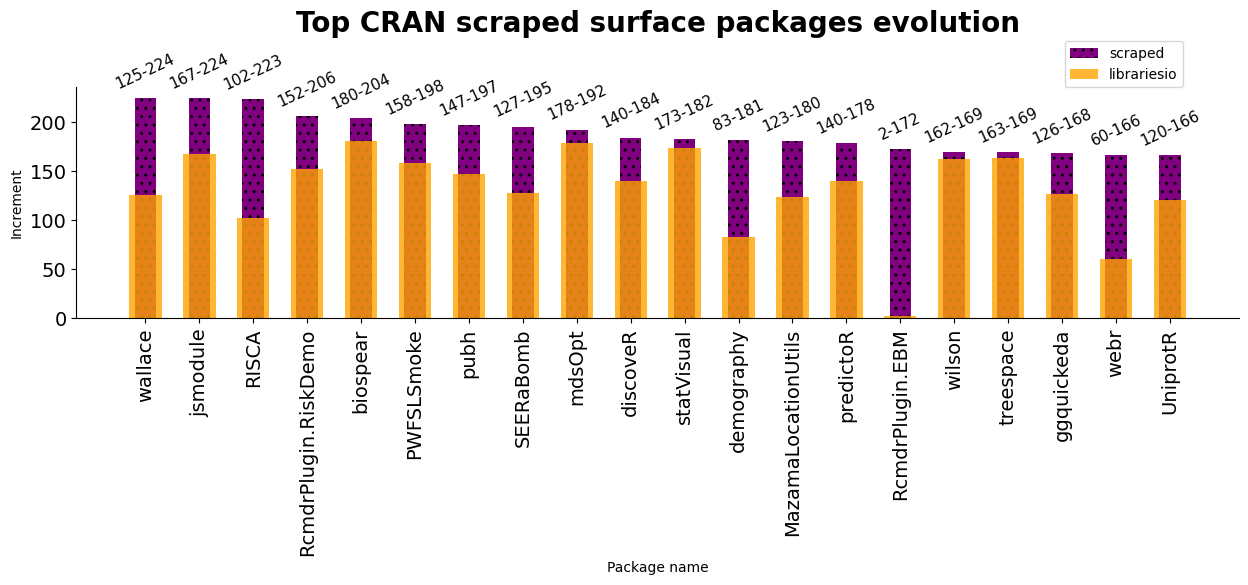

In [62]:
# Evolution of the top scraped surface packages
# ---------------------------------------------

# order surface by scraped value
surface_df.sort_values(by='scraped', ascending=False, inplace=True)
top_surface_scraped = dict(surface_df.head(20)['scraped'])

# Get the surface of the top scraped packages for librariesio model
top_surface_librariesio = {}
for package in top_surface_scraped.keys():
    try:
        top_surface_librariesio[package] = librariesio_surface.results_dict[package]
    except KeyError:
        print(f'Package {package} not found in librariesio model')
        top_surface_librariesio[package] = 0

# Plot the evolution of the top scraped surface packages
plt.figure(figsize=(15, 3))

plt.bar(
    [x[0] for x in top_surface_scraped.items()],
    [x[1] for x in top_surface_scraped.items()],
    label='scraped',
    color='purple',
    width=0.4,
    hatch='..'
)

plt.bar(
    [x[0] for x in top_surface_librariesio.items()],
    [x[1] for x in top_surface_librariesio.items()],
    label='librariesio',
    color='orange',
    width=0.6,
    alpha=0.8,
)

for i, v, v2 in zip([x[0] for x in top_surface_scraped.items()], [x[1] for x in top_surface_scraped.items()], [x[1] for x in top_surface_librariesio.items()]):
    plt.text(i, max(v,v2)+10, f'{int(v2)}-{int(v)}', color='black', ha='center', rotation=25, fontsize=11)

# Adjusting plot borders
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Adjusting tick labels font size
plt.gca().tick_params(axis='x', labelsize=14, rotation=90)
plt.gca().tick_params(axis='y', labelsize=14)
plt.title(f'Top {REPO_NAME} scraped surface packages evolution', fontsize=20, fontweight='bold', pad=40)

plt.xlabel('Package name')
plt.ylabel('Increment')
plt.legend(loc=(0.85,1))

plt.savefig(f'{OUT_IMG_DIR}/top_surface_evolution.png', bbox_inches='tight')
plt.show()


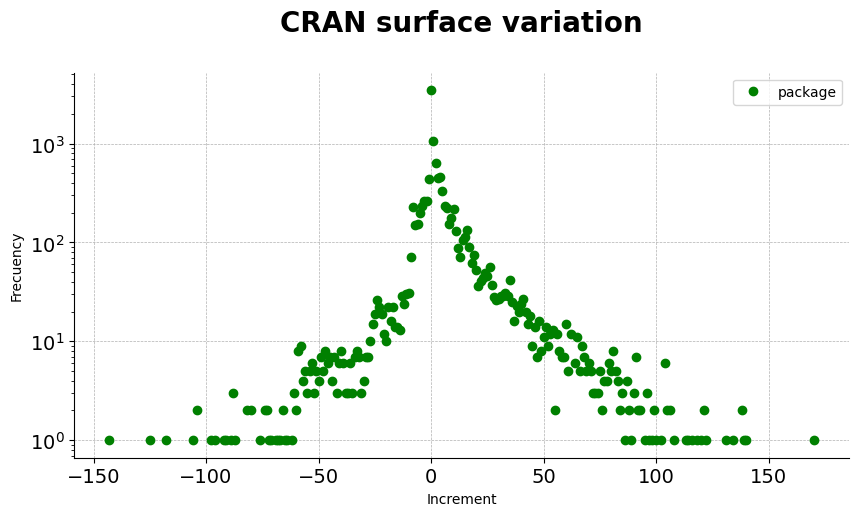

In [80]:
# Surface variation
# ---------------

surface_increase = list(surface_df['increment'].dropna())
surface_increase.sort(reverse=True)

# Plot impact increase
plt.figure(figsize=(10, 5))

surface_increase = [int(x / 1) for x in surface_increase]
x, y = zip(*Counter(surface_increase).items())
plt.plot(x, y, color='green', marker='o', linestyle='None', label='package')
plt.title(f'{REPO_NAME} surface variation', fontsize=20, fontweight='bold', pad=30)

# Adjusting plot borders
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Adjusting tick labels font size
plt.gca().tick_params(axis='x', labelsize=14)
plt.gca().tick_params(axis='y', labelsize=14)
plt.xlabel('Increment')
plt.ylabel('Frecuency')
plt.legend()
plt.grid(axis='x', linestyle='--', linewidth=0.5)
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.xscale('linear')
plt.yscale('log')


plt.savefig(f'{OUT_IMG_DIR}/surface_variation.png', bbox_inches='tight')
plt.show()

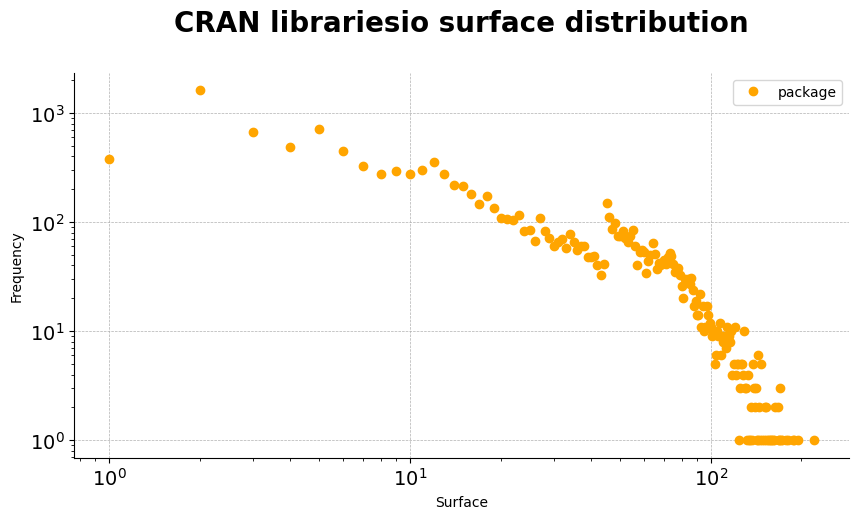

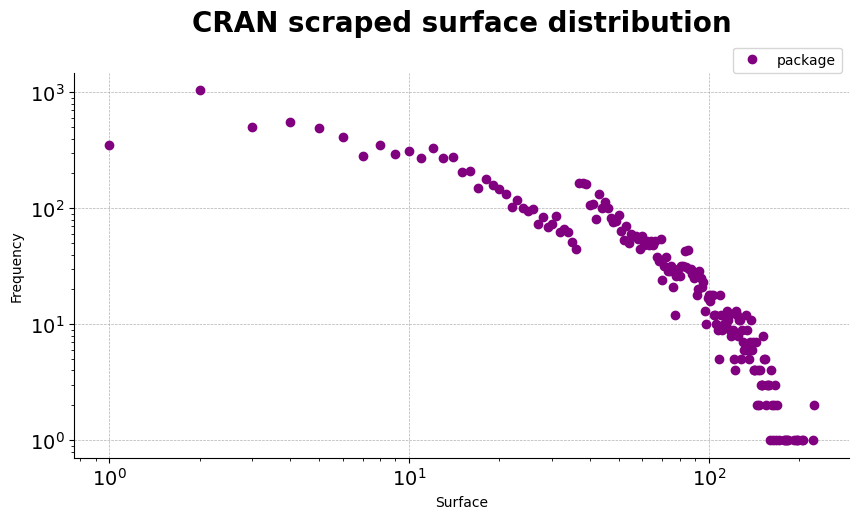

In [64]:
# Surface distribution for libraries.io
# -------------------------------------

# Plot Surface distribution
import statistics


plt.figure(figsize=(10, 5))
surface = list(surface_df['librariesio'].dropna())
x, y = zip(*Counter(surface).items())
plt.plot(x, y, color='orange', marker='o', linestyle='None', label='package')
plt.title(f'{REPO_NAME} librariesio surface distribution', fontsize=20, fontweight='bold', pad=30)

# Adjusting plot borders
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Adjusting tick labels font size
plt.gca().tick_params(axis='x', labelsize=14)
plt.gca().tick_params(axis='y', labelsize=14)
plt.xlabel('Surface')
plt.ylabel('Frequency')
plt.legend()
plt.grid(axis='x', linestyle='--', linewidth=0.5)
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.xscale('log')
plt.yscale('log')

plt.savefig(f'{OUT_IMG_DIR}/librariesio_surface_distribution.png', bbox_inches='tight')
plt.show()

# Surface distribution for scraped
# --------------------------------

# Plot Surface distribution
plt.figure(figsize=(10, 5))
surface = list(surface_df['scraped'].dropna())
x, y = zip(*Counter(surface).items())
plt.plot(x, y, color='purple', marker='o', linestyle='None', label='package')
plt.title(f'{REPO_NAME} scraped surface distribution', fontsize=20, fontweight='bold', pad=30)

# Adjusting plot borders
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Adjusting tick labels font size
plt.gca().tick_params(axis='x', labelsize=14)
plt.gca().tick_params(axis='y', labelsize=14)
plt.xlabel('Surface')
plt.ylabel('Frequency')
plt.legend(loc=(0.85,1))
plt.grid(axis='x', linestyle='--', linewidth=0.5)
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.xscale('log')
plt.yscale('log')


plt.savefig(f'{OUT_IMG_DIR}/scraped_surface_distribution.png', bbox_inches='tight')
plt.show()

#### Dependencies

In [65]:
from olivia.packagemetrics import DependenciesCount

librariesio_dependencies = librariesio_model.get_metric(DependenciesCount)
scraped_dependencies = scraped_model.get_metric(DependenciesCount)

Computing Dependencies Count
Computing Dependencies Count


**Top dependencies**

###### 

In [66]:
# Top 10 dependencies count
# ----------------

top10_librariesio_dependencies_count = librariesio_dependencies.top(10)
top10_scraped_dependencies_count = scraped_dependencies.top(10)

# Top 10 dependencies count comparison
top10_dependencies_count_df = pd.DataFrame(
    {
        'librariesio': top10_librariesio_dependencies_count,
        'scraped': top10_scraped_dependencies_count,
    }
)
top10_dependencies_count_df

librariesio               scraped
0        (CNVScope, 44)          (Seurat, 50)
1          (Seurat, 44)       (immunarch, 46)
2          (smartR, 42)          (pguIMP, 41)
3           (diceR, 40)       (epitweetr, 40)
4  (MetaIntegrator, 37)  (MetaIntegrator, 37)
5          (fdm2id, 37)      (PWFSLSmoke, 36)
6           (dartR, 37)          (iemisc, 36)
7           (maGUI, 37)    (bulkAnalyseR, 36)
8       (metacoder, 36)    (radiant.data, 35)
9        (jsmodule, 36)           (mlmts, 35)

**Bottom dependencies**

###### 

In [67]:
# Top 10 less dependencies count
# ----------------

top10_librariesio_dependencies_count = librariesio_dependencies.bottom(10)
top10_scraped_dependencies_count = librariesio_dependencies.bottom(10)

# Top 10 dependencies count comparison
top10_dependencies_count_df = pd.DataFrame(
    {
        'librariesio': top10_librariesio_dependencies_count,
        'scraped': top10_scraped_dependencies_count,
    }
)
top10_dependencies_count_df

librariesio              scraped
0  (InteractionSet, 0)  (InteractionSet, 0)
1       (LiblineaR, 0)       (LiblineaR, 0)
2   (datetimeutils, 0)   (datetimeutils, 0)
3          (rDNAse, 0)          (rDNAse, 0)
4          (GIGrvg, 0)          (GIGrvg, 0)
5        (ORIClust, 0)        (ORIClust, 0)
6       (AlgDesign, 0)       (AlgDesign, 0)
7          (import, 0)          (import, 0)
8            (KRLS, 0)            (KRLS, 0)
9          (matpow, 0)          (matpow, 0)

**Top dependencies increment**

###### 

In [77]:
# Dataframe with the differences between the two models
librariesio_dependencies_count_df = pd.DataFrame(librariesio_dependencies.results_dict, index=['librariesio']).T
scraped_dependencies_count_df = pd.DataFrame(scraped_dependencies.results_dict, index=['scraped']).T

dependencies_count_df = pd.concat([librariesio_dependencies_count_df, scraped_dependencies_count_df], axis=1)
dependencies_count_df['increment'] = dependencies_count_df['scraped'] - dependencies_count_df['librariesio']
dependencies_count_df.sort_values(by='increment', ascending=False, inplace=True)
dependencies_count_df.head(10)

librariesio  scraped  increment
iemisc                   8.0     36.0       28.0
RISCA                   11.0     33.0       22.0
BrailleR                 1.0     23.0       22.0
BETS                     8.0     28.0       20.0
dragon                  15.0     34.0       19.0
hypervolume              9.0     27.0       18.0
NMF                      4.0     22.0       18.0
FRK                      2.0     20.0       18.0
MplusAutomation          1.0     18.0       17.0
webr                     4.0     21.0       17.0

**Top dependencies decrement**

###### 

In [78]:
# Decrease in dependencies count
# -------------------

# Remove the rows with NaN values
dependencies_count_df = dependencies_count_df.dropna()
dependencies_count_df.tail(10)

librariesio  scraped  increment
psycho               27.0     11.0      -16.0
momentuHMM           32.0     14.0      -18.0
reproducible         32.0     14.0      -18.0
diceR                40.0     21.0      -19.0
DLMtool              29.0      9.0      -20.0
pak                  23.0      3.0      -20.0
RRphylo              29.0      8.0      -21.0
CNVScope             44.0     21.0      -23.0
fdm2id               37.0      7.0      -30.0
maGUI                37.0      4.0      -33.0

**Evolution**

###### 

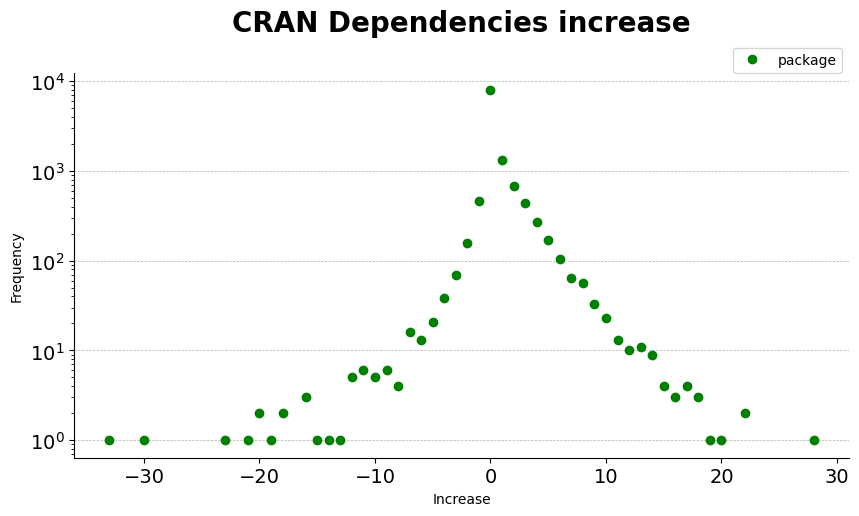

In [79]:
# Dependencies variation
# --------------------------------

dependencies_increase = list(dependencies_count_df['increment'].dropna())
dependencies_increase.sort(reverse=True)

# Plot impact increase
plt.figure(figsize=(10, 5))

# agrupar em intervalos de 100
dependencies_increase = [int(x / 1) for x in dependencies_increase]
x, y = zip(*Counter(dependencies_increase).items())

plt.plot(x, y, color='green', marker='o', linestyle='None', label='package')

# Adjusting plot borders
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Adjusting tick labels font size
plt.gca().tick_params(axis='x', labelsize=14)
plt.gca().tick_params(axis='y', labelsize=14)

plt.title(f'{REPO_NAME} Dependencies increase', fontsize=20, fontweight='bold', pad=30)
plt.ylabel('Frequency')
plt.xlabel('Increase')
plt.xscale('linear')
plt.yscale('log')
plt.legend(loc=(0.85,1))

plt.grid(axis='y', linestyle='--', linewidth=0.5)

plt.savefig(f'{OUT_IMG_DIR}/dependencies_increase.png', bbox_inches='tight')
plt.show()






#### Dependents

In [71]:
from olivia.packagemetrics import DependentsCount

librariesio_dependents = librariesio_model.get_metric(DependentsCount)
scraped_dependents = scraped_model.get_metric(DependentsCount)

Computing Dependents Count
Computing Dependents Count


In [72]:
# Top 10 dependents count
# ----------------

top10_librariesio_dependents_count = librariesio_dependents.top(10)
top10_scraped_dependents_count = scraped_dependents.top(10)

# Top 10 dependents count comparison
top10_dependents_count_df = pd.DataFrame(
    {
        'librariesio': top10_librariesio_dependents_count,
        'scraped': top10_scraped_dependents_count,
    }
)
top10_dependents_count_df

librariesio           scraped
0         (R, 10174)        (R, 12783)
1      (stats, 3834)     (stats, 5660)
2    (methods, 2778)   (methods, 3760)
3      (utils, 2393)     (utils, 3441)
4       (Rcpp, 1878)   (ggplot2, 3192)
5    (ggplot2, 1864)     (dplyr, 3026)
6   (graphics, 1859)      (Rcpp, 2571)
7      (dplyr, 1521)  (graphics, 2381)
8       (MASS, 1368)  (magrittr, 1890)
9  (grDevices, 1142)     (rlang, 1846)

In [73]:
# Top 10 less dependents count
# ----------------------------

top10_librariesio_dependents_count = librariesio_dependents.bottom(10)
top10_scraped_dependents_count = scraped_dependents.bottom(10)

# Top 10 dependents count comparison
top10_dependents_count_df = pd.DataFrame(
    {
        'librariesio': top10_librariesio_dependents_count,
        'scraped': top10_scraped_dependents_count,
    }
)

top10_dependents_count_df

librariesio                 scraped
0     (msaFACE, 0)        (hybridogram, 0)
1      (eulerr, 0)       (hybridModels, 0)
2  (EMMIXcskew, 0)     (hybridEnsemble, 0)
3  (BayesCombo, 0)     (hySpc.testthat, 0)
4     (foghorn, 0)           (hwwntest, 0)
5     (RcppHMM, 0)              (hwsdr, 0)
6   (DecorateR, 0)         (hwordcloud, 0)
7    (echogram, 0)               (hwig, 0)
8         (GPB, 0)               (hwep, 0)
9      (MANCIE, 0)  (controlfunctionIV, 0)

In [74]:
# Dataframe with the differences between the two models
librariesio_dependents_count_df = pd.DataFrame(librariesio_dependents.results_dict, index=['librariesio']).T
scraped_dependents_count_df = pd.DataFrame(scraped_dependents.results_dict, index=['scraped']).T

dependents_count_df = pd.concat([librariesio_dependents_count_df, scraped_dependents_count_df], axis=1)
dependents_count_df['difference'] = dependents_count_df['scraped'] - dependents_count_df['librariesio']
dependents_count_df.sort_values(by='difference', ascending=False, inplace=True)
dependents_count_df.head(10)

librariesio  scraped  difference
R             10174.0  12783.0      2609.0
stats          3834.0   5660.0      1826.0
dplyr          1521.0   3026.0      1505.0
ggplot2        1864.0   3192.0      1328.0
rlang           611.0   1846.0      1235.0
utils          2393.0   3441.0      1048.0
methods        2778.0   3760.0       982.0
magrittr        960.0   1890.0       930.0
tidyr           618.0   1424.0       806.0
tibble          709.0   1485.0       776.0

In [75]:
# Decrease in dependents count
# -------------------

# Remove the rows with NaN values
dependents_count_df = dependents_count_df.dropna()
dependents_count_df['difference'] = dependents_count_df['difference'].abs()
dependents_count_df.tail(10)

librariesio  scraped  difference
gplots          105.0     79.0        26.0
rgl             177.0    151.0        26.0
maptools         94.0     68.0        26.0
rgeos           132.0    100.0        32.0
rgdal           196.0    160.0        36.0
gdata            65.0     27.0        38.0
XML             233.0    192.0        41.0
lazyeval        120.0     76.0        44.0
spatstat         80.0     32.0        48.0
RCurl           209.0    146.0        63.0

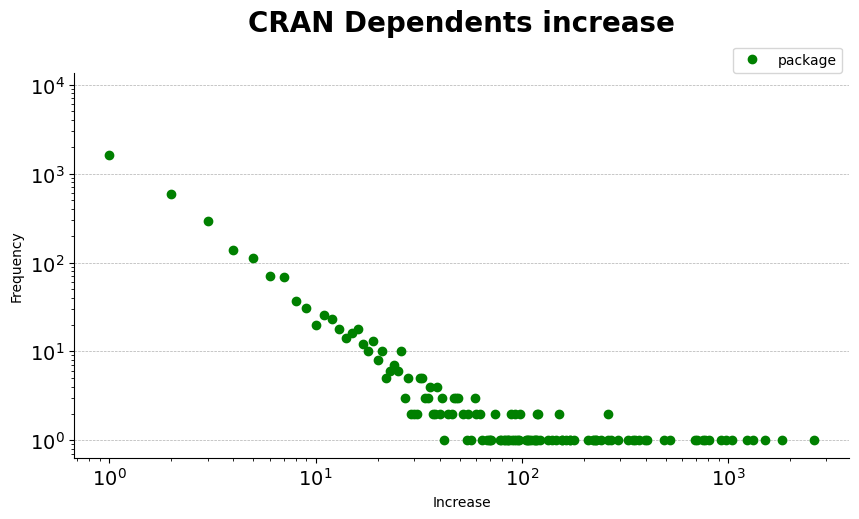

In [81]:
# Dependents variation
# --------------------------------

dependents_increase = list(dependents_count_df['difference'].dropna())
dependents_increase.sort(reverse=True)

# Plot impact increase
plt.figure(figsize=(10, 5))

# agrupar em intervalos de 100
dependents_increase = [int(x / 1)  for x in dependents_increase]
x, y = zip(*Counter(dependents_increase).items())

plt.plot(x, y, color='green', marker='o', linestyle='None', label='package')

# Adjusting plot borders
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Adjusting tick labels font size
plt.gca().tick_params(axis='x', labelsize=14)
plt.gca().tick_params(axis='y', labelsize=14)

plt.title(f'{REPO_NAME} Dependents increase', fontsize=20, fontweight='bold', pad=30)
plt.ylabel('Frequency')
plt.xlabel('Increase')
plt.xscale('log')
plt.yscale('log')
plt.legend(loc=(0.85,1))

plt.grid(axis='y', linestyle='--', linewidth=0.5)

plt.savefig(f'{OUT_IMG_DIR}/dependents_increase.png', bbox_inches='tight')
plt.show()
